In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [2]:
import math

In [3]:
with open('pairs.txt') as f:
    lines = f.readlines()

In [4]:
pairs_dict = {} #maps etf to equities with which it forms a stationary spread
for s in lines:
    pair = s.replace('\n','').split(',')
    etf = pair[1].replace(' ','')
    if etf in pairs_dict.keys():
        pairs_dict[etf].append(pair[0].replace(' ',''))
    else:
        pairs_dict[etf] = [pair[0].replace(' ','')]

In [5]:
print(pairs_dict.keys())

dict_keys(['XLK', 'XLV', 'XLE', 'XLF', 'XLP', 'XLU', 'XLY', 'XLB', 'VIS', 'XLRE'])


In [6]:
etf_dfs = {} #maps etf to dataframe of its price data

for etf in pairs_dict.keys():
    df = yf.Ticker(etf).history(period='max')
    index = df.index
    months = []
    years = []
    days = []
    
    for dt in index:
        years.append(dt.year)
        months.append(dt.month)
        days.append(dt.day)
    
    df['Year'] = pd.Series(years, index = index)
    df['Month'] = pd.Series(months, index = index)
    df['Day'] = pd.Series(days, index = index)
    
    df.reset_index(drop=True, inplace=True)
    
    etf_dfs[etf] = df

# Given outsample spread and position open/close points, compute profit and number of times position is opened/closed

In [7]:
def outsample_pairs_trade(spread, so, lo, sc, lc, max_pos_period):
    #so: short open point
    #lo: long open point
    #sc: short close point
    #lc: long close point
    #max_pos_period: maximum number of days you want the position to be open
    
    prof = 0
    num_trades = 0
    
    short = False
    long_ = False
    open_idx = 0
    
    for idx in range(spread.shape[0]):
        
        if short:
            #currently have an open position where we are shorting the spread
            
            if spread[idx] <= sc or idx - open_idx >= max_pos_period:
                #close the position
                short = False
                prof += spread[open_idx] - spread[idx]
            elif idx == spread.shape[0] - 1:
                #last day of data so close position
                prof += spread[open_idx] - spread[idx]
        
        elif long_:
            #currently have an open position where we are long-ing the spread
            
            if spread[idx] >= lc or idx - open_idx >= max_pos_period:
                #close
                long_ = False
                prof += spread[idx] - spread[open_idx]
            elif idx == spread.shape[0] - 1:
                #last day of data so close position
                prof += spread[idx] - spread[open_idx]
        else:
            
            #determine if we will open a position
            if spread[idx] >= so and idx < spread.shape[0] - 1:
                short = True
                open_idx = idx
                num_trades+=1
            elif spread[idx] <= lo and idx < spread.shape[0] - 1:
                long_ = True
                open_idx = idx
                num_trades+=1
                
    
    return prof, num_trades
    

# Tech

In [8]:
tech_dfs = {} #maps tech symbol to dataframe of merged data between symbol and etf
tech_eqs = pairs_dict['XLK']

for s in tech_eqs:
    df = yf.Ticker(s).history(period='max')
    index = df.index
    months = []
    years = []
    days = []
    
    for dt in index:
        years.append(dt.year)
        months.append(dt.month)
        days.append(dt.day)
    
    df['Year'] = pd.Series(years, index = index)
    df['Month'] = pd.Series(months, index = index)
    df['Day'] = pd.Series(days, index = index)
    
    df.reset_index(drop=True, inplace=True)
    tech_dfs[s] = df.merge(right=etf_dfs['XLK'], how='inner', on=['Year','Month','Day'], suffixes=[None,' ETF'])

In [ ]:
#loop thru equities (each equity, etf pair form a potential stationary spread), construct in sample and out-sample data
# construct spread on in sample data and check stationarity, if stationary, compute mean and SD of spread and actively trade on
#out of sample data, keep track of number of times we open and close a position and profit

In [27]:
tech_prof = {}

for s in tech_eqs:
    merged_data = tech_dfs[s]
    length = merged_data.shape[0]
    samp_len = math.floor(0.75*length)
    insample = merged_data.iloc[0:samp_len]
    outsample = merged_data.iloc[samp_len:]
    
    ols = sm.OLS(np.array(insample['Close']),np.array(insample['Close ETF']))
    res = ols.fit()
    residuals = np.subtract(np.array(insample['Close']),ols.predict(params = res.params))
    pval = adfuller(residuals)[1]
    if pval < .05:
        #stationary
        mean = np.mean(residuals)
        sd = np.std(residuals)
        outsample_spread = np.subtract(np.array(outsample['Close']),np.array(outsample['Close ETF']) * res.params[0])
        #outsample_spread = np.subtract(np.array(outsample['Close']),ols.predict(params = res.params, exog=np.array(outsample['Close ETF'])))
        short_open = mean + 1.5 * sd
        long_open = mean - 1.5 * sd
        long_close = mean - 0.5 * sd
        short_close = mean + 0.5 * sd
        
        prof, num_trades = outsample_pairs_trade(outsample_spread,short_open,long_open,short_close,long_close, 100000)
        tech_prof[s] = (prof, num_trades)
        
        """  if prof < 0:
            plt.figure()
            plt.plot(np.arange(spread.shape[0]),spread,label='spread')
            plt.plot(np.arange(spread.shape[0]),np.ones(spread.shape[0])*short_open, label='so')
            plt.plot(np.arange(spread.shape[0]),np.ones(spread.shape[0])*long_open, label='lo')
            plt.plot(np.arange(spread.shape[0]),np.ones(spread.shape[0])*short_close, label='sc')
            plt.plot(np.arange(spread.shape[0]),np.ones(spread.shape[0])*long_close, label='lc')
            plt.legend()
            plt.title(s)"""
            
    

In [28]:
orig_tech_prof = tech_prof

In [29]:
orig_tech_prof

{'ACON': (0.3435223981633069, 1),
 'ADI': (77.30744974084011, 11),
 'ALKT': (0, 0),
 'ASUR': (-36.49368899403314, 1),
 'ATOM': (4.113338558578807, 2),
 'AULT': (-587941.0629097311, 3),
 'AVDX': (0, 0),
 'BKYI': (-185.75720467223903, 1),
 'BLIN': (-1820.709034138309, 1),
 'BLZE': (0, 0),
 'BRZE': (0.5070042976275104, 1),
 'CNXN': (13.204001644694365, 8),
 'CYN': (0, 0),
 'DMRC': (-66.64038808020709, 3),
 'DSP': (0, 0),
 'DTST': (4.320662652718627, 3),
 'EGAN': (-63.80601615991306, 1),
 'EMAN': (-42.047186212060105, 1),
 'ERII': (13.85262728225061, 4),
 'EZFL': (0, 0),
 'FRSH': (0, 0),
 'GMGI': (0, 0),
 'GROM': (0, 0),
 'HCTI': (0, 0),
 'HLIT': (-37.775455927926345, 1),
 'IMMR': (-40.47925276953323, 1),
 'INVE': (-455.2637128382125, 1),
 'KIND': (0, 0),
 'LPTH': (-94.2048582049457, 1),
 'MGAM': (0, 0),
 'MGRX': (0, 0),
 'MITK': (2.2513758824451564, 5),
 'MSGM': (0, 0),
 'MSTR': (345.70317505730895, 3),
 'MU': (-24.225572816661725, 2),
 'NFTG': (0, 0),
 'NRDS': (4.791142518347506, 1),
 'N

# Healthcare

In [30]:
hc_dfs = {} #maps tech symbol to dataframe of merged data between symbol and etf
hc_eqs = pairs_dict['XLV']

for s in hc_eqs:
    df = yf.Ticker(s).history(period='max')
    index = df.index
    months = []
    years = []
    days = []
    
    for dt in index:
        years.append(dt.year)
        months.append(dt.month)
        days.append(dt.day)
    
    df['Year'] = pd.Series(years, index = index)
    df['Month'] = pd.Series(months, index = index)
    df['Day'] = pd.Series(days, index = index)
    
    df.reset_index(drop=True, inplace=True)
    hc_dfs[s] = df.merge(right=etf_dfs['XLV'], how='inner', on=['Year','Month','Day'], suffixes=[None,' ETF'])

In [31]:
hc_prof = {}

for s in hc_eqs:
    merged_data = hc_dfs[s]
    length = merged_data.shape[0]
    samp_len = math.floor(0.75*length)
    insample = merged_data.iloc[0:samp_len]
    outsample = merged_data.iloc[samp_len:]
    
    ols = sm.OLS(np.array(insample['Close']),np.array(insample['Close ETF']))
    res = ols.fit()
    residuals = np.subtract(np.array(insample['Close']),ols.predict(params = res.params))
    pval = adfuller(residuals)[1]
    if pval < .05:
        #stationary
        mean = np.mean(residuals)
        sd = np.std(residuals)
        outsample_spread = np.subtract(np.array(outsample['Close']),np.array(outsample['Close ETF']) * res.params[0])
        #outsample_spread = np.subtract(np.array(outsample['Close']),ols.predict(params = res.params, exog=np.array(outsample['Close ETF'])))
        short_open = mean + 1.5 * sd
        long_open = mean - 1.5 * sd
        long_close = mean - 0.5 * sd
        short_close = mean + 0.5 * sd
        
        prof, num_trades = outsample_pairs_trade(outsample_spread,short_open,long_open,short_close,long_close, 100000)
        hc_prof[s] = (prof, num_trades)
        

In [32]:
hc_prof

{'ABIO': (0, 0),
 'ABSI': (0, 0),
 'ACGN': (-1385.0257719563629, 1),
 'ACXP': (0.24732325687139411, 1),
 'AGEN': (-14.165844803086202, 1),
 'ALLR': (0, 0),
 'ALPN': (0, 0),
 'ALRN': (0, 0),
 'ALT': (0, 0),
 'ALZN': (0, 0),
 'AMGN': (150.7906422619013, 14),
 'ARAY': (-5.436518753979012, 1),
 'ARMP': (0, 0),
 'ARTL': (0.8044604868546159, 1),
 'ARYD': (0, 0),
 'ATHX': (-15.810539645532145, 2),
 'ATRC': (35.35008560466859, 9),
 'ATXS': (0, 0),
 'AWH': (0, 0),
 'AXLA': (-0.829259272323255, 1),
 'BIAF': (0, 0),
 'BIOC': (0, 0),
 'BIOR': (0, 0),
 'BLFS': (32.60366937525597, 4),
 'BLPH': (0, 0),
 'BNTC': (0, 0),
 'BRTX': (0, 0),
 'CASI': (0, 0),
 'CDMO': (-11.697193167909376, 1),
 'CDXC': (9.157933848931938, 3),
 'CGTX': (0, 0),
 'CLRB': (0, 0),
 'CMPX': (0, 0),
 'CNMD': (67.36787661880862, 13),
 'COCP': (0, 0),
 'COLL': (5.202151320768461, 1),
 'CPIX': (-7.057342568839358, 1),
 'CRIS': (-27.063433239368297, 1),
 'CRMD': (-1.3958570685070733, 1),
 'CTSO': (-0.6817622768469178, 1),
 'CVKD': (0,

# Energy

In [33]:
energy_dfs = {} #maps tech symbol to dataframe of merged data between symbol and etf
energy_eqs = pairs_dict['XLE']

for s in energy_eqs:
    df = yf.Ticker(s).history(period='max')
    index = df.index
    months = []
    years = []
    days = []
    
    for dt in index:
        years.append(dt.year)
        months.append(dt.month)
        days.append(dt.day)
    
    df['Year'] = pd.Series(years, index = index)
    df['Month'] = pd.Series(months, index = index)
    df['Day'] = pd.Series(days, index = index)
    
    df.reset_index(drop=True, inplace=True)
    energy_dfs[s] = df.merge(right=etf_dfs['XLE'], how='inner', on=['Year','Month','Day'], suffixes=[None,' ETF'])

In [34]:
energy_prof = {}

for s in energy_eqs:
    merged_data = energy_dfs[s]
    length = merged_data.shape[0]
    samp_len = math.floor(0.75*length)
    insample = merged_data.iloc[0:samp_len]
    outsample = merged_data.iloc[samp_len:]
    
    ols = sm.OLS(np.array(insample['Close']),np.array(insample['Close ETF']))
    res = ols.fit()
    residuals = np.subtract(np.array(insample['Close']),ols.predict(params = res.params))
    pval = adfuller(residuals)[1]
    if pval < .05:
        #stationary
        mean = np.mean(residuals)
        sd = np.std(residuals)
        outsample_spread = np.subtract(np.array(outsample['Close']),np.array(outsample['Close ETF']) * res.params[0])
        #outsample_spread = np.subtract(np.array(outsample['Close']),ols.predict(params = res.params, exog=np.array(outsample['Close ETF'])))
        short_open = mean + 1.5 * sd
        long_open = mean - 1.5 * sd
        long_close = mean - 0.5 * sd
        short_close = mean + 0.5 * sd
        
        prof, num_trades = outsample_pairs_trade(outsample_spread,short_open,long_open,short_close,long_close, 100000)
        energy_prof[s] = (prof, num_trades)
        

In [35]:
energy_prof

{'AE': (23.259924186848224, 4),
 'AMPY': (0, 0),
 'AROC': (0.8360272390749834, 1),
 'BNMV': (0, 0),
 'BSM': (5.499953956452423, 5),
 'CEI': (0, 0),
 'CKX': (4.629815030407199, 7),
 'EPM': (0, 0),
 'GBR': (18.412896269909293, 1),
 'HPK': (5.46403206686991, 2),
 'KNTK': (8.046044277046043, 1),
 'KRP': (4.919144349951884, 4),
 'MXC': (9.505912990184616, 1),
 'NFG': (26.803182931094586, 6),
 'PARR': (6.387726415577788, 2),
 'PLUG': (0, 0),
 'POWL': (25.871301494065783, 6),
 'RNGR': (4.835614508334764, 2),
 'VIVK': (0, 0),
 'VTNR': (0, 0)}

# Financials

In [36]:
fin_dfs = {} #maps tech symbol to dataframe of merged data between symbol and etf
fin_eqs = pairs_dict['XLF']

for s in fin_eqs:
    df = yf.Ticker(s).history(period='max')
    index = df.index
    months = []
    years = []
    days = []
    
    for dt in index:
        years.append(dt.year)
        months.append(dt.month)
        days.append(dt.day)
    
    df['Year'] = pd.Series(years, index = index)
    df['Month'] = pd.Series(months, index = index)
    df['Day'] = pd.Series(days, index = index)
    
    df.reset_index(drop=True, inplace=True)
    fin_dfs[s] = df.merge(right=etf_dfs['XLF'], how='inner', on=['Year','Month','Day'], suffixes=[None,' ETF'])

In [37]:
fin_prof = {}

for s in fin_eqs:
    merged_data = fin_dfs[s]
    length = merged_data.shape[0]
    samp_len = math.floor(0.75*length)
    insample = merged_data.iloc[0:samp_len]
    outsample = merged_data.iloc[samp_len:]
    
    ols = sm.OLS(np.array(insample['Close']),np.array(insample['Close ETF']))
    res = ols.fit()
    residuals = np.subtract(np.array(insample['Close']),ols.predict(params = res.params))
    pval = adfuller(residuals)[1]
    if pval < .05:
        #stationary
        mean = np.mean(residuals)
        sd = np.std(residuals)
        outsample_spread = np.subtract(np.array(outsample['Close']),np.array(outsample['Close ETF']) * res.params[0])
        #outsample_spread = np.subtract(np.array(outsample['Close']),ols.predict(params = res.params, exog=np.array(outsample['Close ETF'])))
        short_open = mean + 1.5 * sd
        long_open = mean - 1.5 * sd
        long_close = mean - 0.5 * sd
        short_close = mean + 0.5 * sd
        
        prof, num_trades = outsample_pairs_trade(outsample_spread,short_open,long_open,short_close,long_close, 100000)
        fin_prof[s] = (prof, num_trades)
        

In [38]:
fin_prof

{'APCX': (0.6283996569571668, 3),
 'ASRV': (-1.824097073443271, 1),
 'AVTA': (0, 0),
 'BCOW': (0.8387507556379532, 4),
 'BGCP': (2.616267299403801, 2),
 'BHF': (0, 0),
 'BOC': (3.0107534536440994, 2),
 'BTCS': (0, 0),
 'CCAP': (3.3417723488027544, 3),
 'CWD': (0, 0),
 'EQH': (6.682459143441292, 3),
 'FICV': (0.3821915688170563, 1),
 'FINV': (1.9040696919109887, 1),
 'GREE': (1165.8364569782532, 3),
 'HFBL': (10.89033286428478, 4),
 'HGBL': (0, 0),
 'LC': (0, 0),
 'MAIN': (7.80560333421996, 3),
 'MCVT': (3.6342956985475667, 3),
 'NCPL': (0, 0),
 'PBBK': (1.2217094855130028, 1),
 'QQQX': (3.7184959245286198, 3),
 'RCAC': (0.2727215716110969, 1),
 'SAZ': (0, 0),
 'SDIG': (0, 0),
 'SIEB': (14.70832246278282, 4),
 'SWKH': (0, 0),
 'WHF': (4.0421295325268165, 6)}

# Consumer Staples

In [39]:
cs_dfs = {} #maps tech symbol to dataframe of merged data between symbol and etf
cs_eqs = pairs_dict['XLP']

for s in cs_eqs:
    df = yf.Ticker(s).history(period='max')
    index = df.index
    months = []
    years = []
    days = []
    
    for dt in index:
        years.append(dt.year)
        months.append(dt.month)
        days.append(dt.day)
    
    df['Year'] = pd.Series(years, index = index)
    df['Month'] = pd.Series(months, index = index)
    df['Day'] = pd.Series(days, index = index)
    
    df.reset_index(drop=True, inplace=True)
    cs_dfs[s] = df.merge(right=etf_dfs['XLP'], how='inner', on=['Year','Month','Day'], suffixes=[None,' ETF'])

In [40]:
cs_prof = {}

for s in cs_eqs:
    merged_data = cs_dfs[s]
    length = merged_data.shape[0]
    samp_len = math.floor(0.75*length)
    insample = merged_data.iloc[0:samp_len]
    outsample = merged_data.iloc[samp_len:]
    
    ols = sm.OLS(np.array(insample['Close']),np.array(insample['Close ETF']))
    res = ols.fit()
    residuals = np.subtract(np.array(insample['Close']),ols.predict(params = res.params))
    pval = adfuller(residuals)[1]
    if pval < .05:
        #stationary
        mean = np.mean(residuals)
        sd = np.std(residuals)
        outsample_spread = np.subtract(np.array(outsample['Close']),np.array(outsample['Close ETF']) * res.params[0])
        #outsample_spread = np.subtract(np.array(outsample['Close']),ols.predict(params = res.params, exog=np.array(outsample['Close ETF'])))
        short_open = mean + 1.5 * sd
        long_open = mean - 1.5 * sd
        long_close = mean - 0.5 * sd
        short_close = mean + 0.5 * sd
        
        prof, num_trades = outsample_pairs_trade(outsample_spread,short_open,long_open,short_close,long_close, 100000)
        cs_prof[s] = (prof, num_trades)
        

In [41]:
cs_prof

{'ARLO': (0, 0),
 'DNUT': (2.8491899390764495, 1),
 'EDBL': (0, 0),
 'MDLZ': (13.561588523153688, 10),
 'MDVL': (0, 0),
 'RAD': (-123.26369993413667, 1),
 'WTER': (0, 0)}

# Utilities

In [42]:
util_dfs = {} #maps tech symbol to dataframe of merged data between symbol and etf
util_eqs = pairs_dict['XLU']

for s in util_eqs:
    df = yf.Ticker(s).history(period='max')
    index = df.index
    months = []
    years = []
    days = []
    
    for dt in index:
        years.append(dt.year)
        months.append(dt.month)
        days.append(dt.day)
    
    df['Year'] = pd.Series(years, index = index)
    df['Month'] = pd.Series(months, index = index)
    df['Day'] = pd.Series(days, index = index)
    
    df.reset_index(drop=True, inplace=True)
    util_dfs[s] = df.merge(right=etf_dfs['XLU'], how='inner', on=['Year','Month','Day'], suffixes=[None,' ETF'])

In [43]:
util_prof = {}

for s in util_eqs:
    merged_data = util_dfs[s]
    length = merged_data.shape[0]
    samp_len = math.floor(0.75*length)
    insample = merged_data.iloc[0:samp_len]
    outsample = merged_data.iloc[samp_len:]
    
    ols = sm.OLS(np.array(insample['Close']),np.array(insample['Close ETF']))
    res = ols.fit()
    residuals = np.subtract(np.array(insample['Close']),ols.predict(params = res.params))
    pval = adfuller(residuals)[1]
    if pval < .05:
        #stationary
        mean = np.mean(residuals)
        sd = np.std(residuals)
        outsample_spread = np.subtract(np.array(outsample['Close']),np.array(outsample['Close ETF']) * res.params[0])
        #outsample_spread = np.subtract(np.array(outsample['Close']),ols.predict(params = res.params, exog=np.array(outsample['Close ETF'])))
        short_open = mean + 1.5 * sd
        long_open = mean - 1.5 * sd
        long_close = mean - 0.5 * sd
        short_close = mean + 0.5 * sd
        
        prof, num_trades = outsample_pairs_trade(outsample_spread,short_open,long_open,short_close,long_close, 100000)
        util_prof[s] = (prof, num_trades)
        

In [44]:
util_prof

{'CLFD': (1.4619086808289978, 2),
 'DZSI': (0, 0),
 'OIG': (0, 0),
 'SJW': (-2.3722264927904533, 3)}

# Consumer Discretionary

In [45]:
cd_dfs = {} #maps tech symbol to dataframe of merged data between symbol and etf
cd_eqs = pairs_dict['XLY']

for s in cd_eqs:
    df = yf.Ticker(s).history(period='max')
    index = df.index
    months = []
    years = []
    days = []
    
    for dt in index:
        years.append(dt.year)
        months.append(dt.month)
        days.append(dt.day)
    
    df['Year'] = pd.Series(years, index = index)
    df['Month'] = pd.Series(months, index = index)
    df['Day'] = pd.Series(days, index = index)
    
    df.reset_index(drop=True, inplace=True)
    cd_dfs[s] = df.merge(right=etf_dfs['XLY'], how='inner', on=['Year','Month','Day'], suffixes=[None,' ETF'])

In [46]:
cd_prof = {}

for s in cd_eqs:
    merged_data = cd_dfs[s]
    length = merged_data.shape[0]
    samp_len = math.floor(0.75*length)
    insample = merged_data.iloc[0:samp_len]
    outsample = merged_data.iloc[samp_len:]
    
    ols = sm.OLS(np.array(insample['Close']),np.array(insample['Close ETF']))
    res = ols.fit()
    residuals = np.subtract(np.array(insample['Close']),ols.predict(params = res.params))
    pval = adfuller(residuals)[1]
    if pval < .05:
        #stationary
        mean = np.mean(residuals)
        sd = np.std(residuals)
        outsample_spread = np.subtract(np.array(outsample['Close']),np.array(outsample['Close ETF']) * res.params[0])
        #outsample_spread = np.subtract(np.array(outsample['Close']),ols.predict(params = res.params, exog=np.array(outsample['Close ETF'])))
        short_open = mean + 1.5 * sd
        long_open = mean - 1.5 * sd
        long_close = mean - 0.5 * sd
        short_close = mean + 0.5 * sd
        
        prof, num_trades = outsample_pairs_trade(outsample_spread,short_open,long_open,short_close,long_close, 100000)
        cd_prof[s] = (prof, num_trades)
        

In [47]:
cd_prof

{'AIRT': (78.99383430889199, 18),
 'AKAM': (-5.920759973245509, 1),
 'AMEH': (-5.753917415615245, 1),
 'APDN': (0, 0),
 'APRN': (0, 0),
 'ASH': (29.596562815808966, 7),
 'BIRD': (0, 0),
 'BLNK': (0, 0),
 'BSQR': (7.659994558958946, 1),
 'CCOI': (57.12150350554008, 7),
 'CLAR': (7.327346019374481, 2),
 'CLX': (27.78362093677589, 7),
 'COLM': (-6.27862222844697, 4),
 'COMS': (0, 0),
 'CRGE': (0, 0),
 'CSV': (10.963505663886014, 5),
 'CUEN': (0, 0),
 'DLPN': (0, 0),
 'DSS': (-516.7047060057167, 1),
 'EBAY': (17.489173280971634, 7),
 'EGIO': (-0.45809170200788163, 2),
 'EVTV': (0, 0),
 'FAT': (2.0747860400357254, 1),
 'FC': (33.74686317285336, 7),
 'GNK': (0, 0),
 'GNLN': (0, 0),
 'GNTX': (9.397454391804605, 9),
 'GNUS': (0, 0),
 'GRBK': (0, 0),
 'GRPN': (-43.208091094686296, 1),
 'GSAT': (0.6007444108954259, 1),
 'HCKT': (6.000319076717467, 1),
 'HOUR': (-0.308095840492872, 1),
 'IDEX': (0, 0),
 'ISDR': (22.329490696901495, 7),
 'IZEA': (0, 0),
 'JOUT': (24.609153368541065, 5),
 'KFRC': (

# Basic Materials

In [48]:
bm_dfs = {} #maps tech symbol to dataframe of merged data between symbol and etf
bm_eqs = pairs_dict['XLB']

for s in bm_eqs:
    df = yf.Ticker(s).history(period='max')
    index = df.index
    months = []
    years = []
    days = []
    
    for dt in index:
        years.append(dt.year)
        months.append(dt.month)
        days.append(dt.day)
    
    df['Year'] = pd.Series(years, index = index)
    df['Month'] = pd.Series(months, index = index)
    df['Day'] = pd.Series(days, index = index)
    
    df.reset_index(drop=True, inplace=True)
    bm_dfs[s] = df.merge(right=etf_dfs['XLB'], how='inner', on=['Year','Month','Day'], suffixes=[None,' ETF'])

In [49]:
bm_prof = {}

for s in bm_eqs:
    merged_data = bm_dfs[s]
    length = merged_data.shape[0]
    samp_len = math.floor(0.75*length)
    insample = merged_data.iloc[0:samp_len]
    outsample = merged_data.iloc[samp_len:]
    
    ols = sm.OLS(np.array(insample['Close']),np.array(insample['Close ETF']))
    res = ols.fit()
    residuals = np.subtract(np.array(insample['Close']),ols.predict(params = res.params))
    pval = adfuller(residuals)[1]
    if pval < .05:
        #stationary
        mean = np.mean(residuals)
        sd = np.std(residuals)
        outsample_spread = np.subtract(np.array(outsample['Close']),np.array(outsample['Close ETF']) * res.params[0])
        #outsample_spread = np.subtract(np.array(outsample['Close']),ols.predict(params = res.params, exog=np.array(outsample['Close ETF'])))
        short_open = mean + 1.5 * sd
        long_open = mean - 1.5 * sd
        long_close = mean - 0.5 * sd
        short_close = mean + 0.5 * sd
        
        prof, num_trades = outsample_pairs_trade(outsample_spread,short_open,long_open,short_close,long_close, 100000)
        bm_prof[s] = (prof, num_trades)
        

In [50]:
bm_prof

{}

# Industrials

In [51]:
ind_dfs = {} #maps tech symbol to dataframe of merged data between symbol and etf
ind_eqs = pairs_dict['VIS']

for s in ind_eqs:
    df = yf.Ticker(s).history(period='max')
    index = df.index
    months = []
    years = []
    days = []
    
    for dt in index:
        years.append(dt.year)
        months.append(dt.month)
        days.append(dt.day)
    
    df['Year'] = pd.Series(years, index = index)
    df['Month'] = pd.Series(months, index = index)
    df['Day'] = pd.Series(days, index = index)
    
    df.reset_index(drop=True, inplace=True)
    ind_dfs[s] = df.merge(right=etf_dfs['VIS'], how='inner', on=['Year','Month','Day'], suffixes=[None,' ETF'])

In [52]:
ind_prof = {}

for s in ind_eqs:
    merged_data = ind_dfs[s]
    length = merged_data.shape[0]
    samp_len = math.floor(0.75*length)
    insample = merged_data.iloc[0:samp_len]
    outsample = merged_data.iloc[samp_len:]
    
    ols = sm.OLS(np.array(insample['Close']),np.array(insample['Close ETF']))
    res = ols.fit()
    residuals = np.subtract(np.array(insample['Close']),ols.predict(params = res.params))
    pval = adfuller(residuals)[1]
    if pval < .05:
        #stationary
        mean = np.mean(residuals)
        sd = np.std(residuals)
        outsample_spread = np.subtract(np.array(outsample['Close']),np.array(outsample['Close ETF']) * res.params[0])
        #outsample_spread = np.subtract(np.array(outsample['Close']),ols.predict(params = res.params, exog=np.array(outsample['Close ETF'])))
        short_open = mean + 1.5 * sd
        long_open = mean - 1.5 * sd
        long_close = mean - 0.5 * sd
        short_close = mean + 0.5 * sd
        
        prof, num_trades = outsample_pairs_trade(outsample_spread,short_open,long_open,short_close,long_close, 100000)
        ind_prof[s] = (prof, num_trades)
        

In [53]:
ind_prof

{'AKYA': (-3.854970482089511, 1),
 'AMTX': (0, 0),
 'ASTC': (-19.93920913282807, 1),
 'BNGO': (0, 0),
 'CEAD': (0, 0),
 'EKSO': (0, 0),
 'EYPT': (-5.869265908225685, 1),
 'FIP': (0.43403178376811224, 3),
 'FRZA': (0, 0),
 'GEVO': (0, 0),
 'GPRE': (8.242796822097624, 1),
 'HTGM': (0, 0),
 'HUN': (-2.7156340152619336, 2),
 'IESC': (0, 0),
 'KTOS': (0, 0),
 'LWLG': (-3.3817437395791354, 3),
 'NPO': (49.56538163253599, 7),
 'PGTI': (4.0718739373558215, 1),
 'PRPO': (0, 0),
 'RKDA': (0, 0),
 'SNES': (0, 0),
 'UAVS': (0, 0),
 'WAT': (49.81881940910074, 3),
 'WLFC': (50.091540737994144, 12),
 'WLKP': (6.598313043300944, 4),
 'WNC': (6.847507479162669, 1),
 'ALPP': (0, 0),
 'AMPG': (0, 0),
 'MITQ': (0, 0),
 'NXPL': (0, 0),
 'SONM': (0, 0)}

# Real Estate

In [54]:
re_dfs = {} #maps tech symbol to dataframe of merged data between symbol and etf
re_eqs = pairs_dict['XLRE']

for s in re_eqs:
    df = yf.Ticker(s).history(period='max')
    index = df.index
    months = []
    years = []
    days = []
    
    for dt in index:
        years.append(dt.year)
        months.append(dt.month)
        days.append(dt.day)
    
    df['Year'] = pd.Series(years, index = index)
    df['Month'] = pd.Series(months, index = index)
    df['Day'] = pd.Series(days, index = index)
    
    df.reset_index(drop=True, inplace=True)
    re_dfs[s] = df.merge(right=etf_dfs['XLRE'], how='inner', on=['Year','Month','Day'], suffixes=[None,' ETF'])

In [55]:
re_prof = {}

for s in re_eqs:
    merged_data = re_dfs[s]
    length = merged_data.shape[0]
    samp_len = math.floor(0.75*length)
    insample = merged_data.iloc[0:samp_len]
    outsample = merged_data.iloc[samp_len:]
    
    ols = sm.OLS(np.array(insample['Close']),np.array(insample['Close ETF']))
    res = ols.fit()
    residuals = np.subtract(np.array(insample['Close']),ols.predict(params = res.params))
    pval = adfuller(residuals)[1]
    if pval < .05:
        #stationary
        mean = np.mean(residuals)
        sd = np.std(residuals)
        outsample_spread = np.subtract(np.array(outsample['Close']),np.array(outsample['Close ETF']) * res.params[0])
        #outsample_spread = np.subtract(np.array(outsample['Close']),ols.predict(params = res.params, exog=np.array(outsample['Close ETF'])))
        short_open = mean + 1.5 * sd
        long_open = mean - 1.5 * sd
        long_close = mean - 0.5 * sd
        short_close = mean + 0.5 * sd
        
        prof, num_trades = outsample_pairs_trade(outsample_spread,short_open,long_open,short_close,long_close, 100000)
        re_prof[s] = (prof, num_trades)
        

In [56]:
re_prof

{'CSR': (18.330119204584605, 3),
 'GIPR': (0.4710014455766931, 2),
 'HTIA': (3.34493422018328, 3),
 'IHT': (2.7153064305496977, 1),
 'INTG': (46.78540139449695, 8),
 'PMT': (4.818921023098358, 2),
 'SCCB': (2.7237144889591534, 2),
 'SCCD': (0, 0),
 'SCCF': (1.1824824046929763, 1),
 'VINO': (0, 0)}

In [58]:
prof_dict_list = [tech_prof, hc_prof, energy_prof, re_prof, ind_prof, bm_prof, cd_prof, cs_prof, util_prof,fin_prof]
good_pairs = []

for d in prof_dict_list:
    
    for item in d.items():
        eq = item[0]
        tup = item[1]
        if tup[0] > 0:
            if d == tech_prof:
                good_pairs.append((eq,'XLK'))
            elif d == hc_prof:
                good_pairs.append((eq,'XLV'))
            elif d == energy_prof:
                good_pairs.append((eq,'XLE'))
            elif d == re_prof:
                good_pairs.append((eq,'XLRE'))
            elif d == ind_prof:
                good_pairs.append((eq,'VIS'))
            elif d == bm_prof:
                good_pairs.append((eq,'XLB'))
            elif d == cd_prof:
                good_pairs.append((eq,'XLY'))
            elif d == cs_prof:
                good_pairs.append((eq,'XLP'))
            elif d == util_prof:
                good_pairs.append((eq,'XLU'))
            else:
                good_pairs.append((eq,'XLF'))
                

In [59]:
good_pairs

[('ACON', 'XLK'),
 ('ADI', 'XLK'),
 ('ATOM', 'XLK'),
 ('BRZE', 'XLK'),
 ('CNXN', 'XLK'),
 ('DTST', 'XLK'),
 ('ERII', 'XLK'),
 ('MITK', 'XLK'),
 ('MSTR', 'XLK'),
 ('NRDS', 'XLK'),
 ('NSIT', 'XLK'),
 ('POWI', 'XLK'),
 ('PTC', 'XLK'),
 ('RUM', 'XLK'),
 ('TENB', 'XLK'),
 ('TXN', 'XLK'),
 ('WAVD', 'XLK'),
 ('XPON', 'XLK'),
 ('ACXP', 'XLV'),
 ('AMGN', 'XLV'),
 ('ARTL', 'XLV'),
 ('ATRC', 'XLV'),
 ('BLFS', 'XLV'),
 ('CDXC', 'XLV'),
 ('CNMD', 'XLV'),
 ('COLL', 'XLV'),
 ('DERM', 'XLV'),
 ('DTOC', 'XLV'),
 ('EXEL', 'XLV'),
 ('HALO', 'XLV'),
 ('HCWB', 'XLV'),
 ('IBRX', 'XLV'),
 ('INO', 'XLV'),
 ('LUCY', 'XLV'),
 ('MNPR', 'XLV'),
 ('NTRB', 'XLV'),
 ('PMGM', 'XLV'),
 ('PROK', 'XLV'),
 ('RAPT', 'XLV'),
 ('RCLF', 'XLV'),
 ('SCLX', 'XLV'),
 ('SEM', 'XLV'),
 ('SRPT', 'XLV'),
 ('STSS', 'XLV'),
 ('UPXI', 'XLV'),
 ('ZIVO', 'XLV'),
 ('AE', 'XLE'),
 ('AROC', 'XLE'),
 ('BSM', 'XLE'),
 ('CKX', 'XLE'),
 ('GBR', 'XLE'),
 ('HPK', 'XLE'),
 ('KNTK', 'XLE'),
 ('KRP', 'XLE'),
 ('MXC', 'XLE'),
 ('NFG', 'XLE'),
 ('PARR

In [60]:
len(good_pairs)

122

good_pairs is a list of tuples such that each tuple is a stock-ETF pair whose in-sample spread was stationary  and whose profitability using a naive pairs trading strategy on out of sample data was positive

In [74]:
def outsample_pairs_trade_2(spread, so, lo, sc, lc, eq_prices, etf_prices, beta):
    
    #same as original function except computes prof/trade and return on committed capital (cc) where cc = price of what we buy when we open position 
    #so: short open point
    #lo: long open point
    #sc: short close point
    #lc: long close point

    
    prof = 0
    num_trades = 0
    cc = 0
    short = False
    long_ = False
    open_idx = 0
    
    for idx in range((spread.shape[0])):
        
        if short:
            #currently have an open position where we are shorting the spread
            
            if spread[idx] <= sc:
                #close the position
                short = False
                prof += spread[open_idx] - spread[idx]
            elif idx == spread.shape[0] - 1:
                #last day of data so close position
                prof += spread[open_idx] - spread[idx]
        
        elif long_:
            #currently have an open position where we are long-ing the spread
            
            if spread[idx] >= lc:
                #close
                long_ = False
                prof += spread[idx] - spread[open_idx]
            elif idx == spread.shape[0] - 1:
                #last day of data so close position
                prof += spread[idx] - spread[open_idx]
        else:
            
            #determine if we will open a position
            if spread[idx] >= so and idx < spread.shape[0] - 1:
                #selling 1 share of eq and buying beta share of etf
                cc += beta * etf_prices[idx]
                short = True
                open_idx = idx
                num_trades+=1
            elif spread[idx] <= lo and idx < spread.shape[0] - 1:
                #buying 1 share of eq and selling beta share of etf
                cc += eq_prices[idx]
                long_ = True
                open_idx = idx
                num_trades+=1
                
    
    return prof/num_trades, prof/cc
    

In [75]:
good_pairs_dict = {} #maps good pairs to a 2-tuple (prof/trade, return from commmited capital)
for pair in good_pairs:
    etf = pair[1]
    eq = pair[0]
    if etf == 'XLK':
        merged_data = tech_dfs[eq]
    elif etf == 'XLV':
        merged_data = hc_dfs[eq]
    elif etf == 'XLE':
        merged_data = energy_dfs[eq]
    elif etf == 'XLRE':
        merged_data = re_dfs[eq]
    elif etf == 'VIS':
        merged_data = ind_dfs[eq]
    elif etf == 'XLY':
        merged_data = cd_dfs[eq]
    elif etf == 'XLP':
        merged_data = cs_dfs[eq]
    elif etf == 'XLU':
        merged_data = util_dfs[eq]
    elif etf == 'XLF':
        merged_data = fin_dfs[eq]
    
    length = merged_data.shape[0]
    sample_len = math.floor(length*0.75)
    insample = merged_data.iloc[0:sample_len]
    outsample = merged_data.iloc[sample_len:]
    ols = sm.OLS(np.array(insample['Close']),np.array(insample['Close ETF']))
    res = ols.fit()
    beta = res.params[0]
    insample_spread = np.subtract(np.array(insample['Close']),beta*np.array(insample['Close ETF']))
    mean = np.mean(insample_spread)
    sd = np.std(insample_spread)
    spread = np.subtract(np.array(outsample['Close']),beta*np.array(outsample['Close ETF']))
    short_open = mean + 1.5 * sd
    long_open = mean - 1.5 * sd
    long_close = mean - 0.5 * sd
    short_close = mean + 0.5 * sd
    prof_per_trade, ret_on_cc = outsample_pairs_trade_2(spread,short_open,long_open,short_close,long_close, np.array(outsample['Close']),np.array(outsample['Close ETF']), beta)
    num_years = outsample.shape[0]/365
    good_pairs_dict[pair] = (prof_per_trade, ret_on_cc, num_years)
    

In [76]:
good_pairs_dict

{('ACON', 'XLK'): (0.3435223981633069,
  0.5452736520053559,
  0.19452054794520549),
 ('ADI', 'XLK'): (7.02794997644001, 0.057008205065174, 4.213698630136986),
 ('ATOM', 'XLK'): (2.0566692792894035, 0.17382168029096817, 1.178082191780822),
 ('BRZE', 'XLK'): (0.5070042976275104,
  0.01887581109853424,
  0.26575342465753427),
 ('CNXN', 'XLK'): (1.6505002055867957,
  0.047136377803776094,
  4.213698630136986),
 ('DTST', 'XLK'): (1.4402208842395423, 5.577381393307223, 1.936986301369863),
 ('ERII', 'XLK'): (3.4631568205626526, 0.2043251925739441, 2.5753424657534247),
 ('MITK', 'XLK'): (0.45027517648903126,
  0.04522654998232433,
  4.213698630136986),
 ('MSTR', 'XLK'): (115.23439168576965, 0.2403199568969356, 4.213698630136986),
 ('NRDS', 'XLK'): (4.791142518347506, 0.38725097036682404, 0.273972602739726),
 ('NSIT', 'XLK'): (7.2963568046631035, 0.09208366825481476, 4.213698630136986),
 ('POWI', 'XLK'): (6.051383179110255, 0.0833875530781029, 4.213698630136986),
 ('PTC', 'XLK'): (8.2952842525

/var/folders/8r/fr9y19j57554vvz5607f_l4h0000gn/T/ipykernel_72117/628072967.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


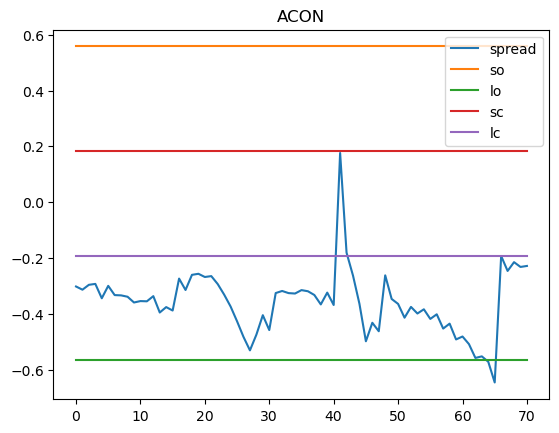

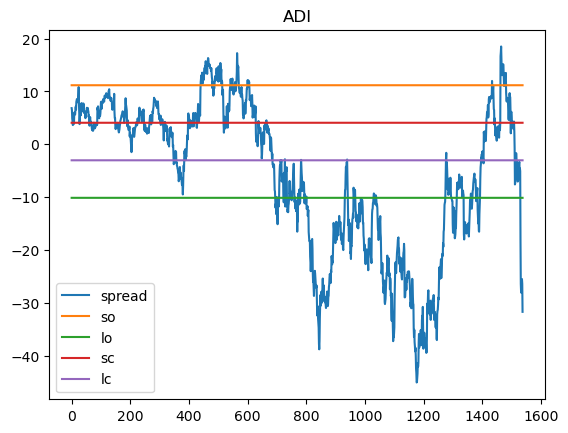

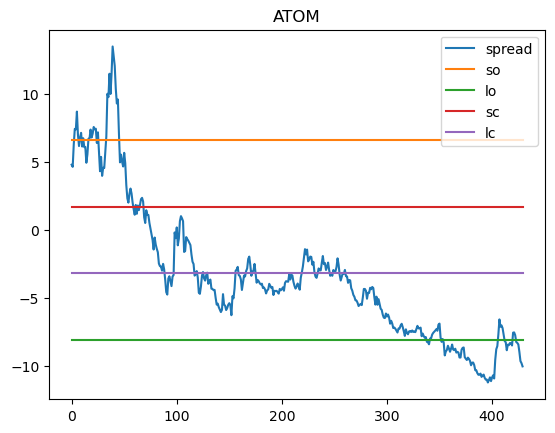

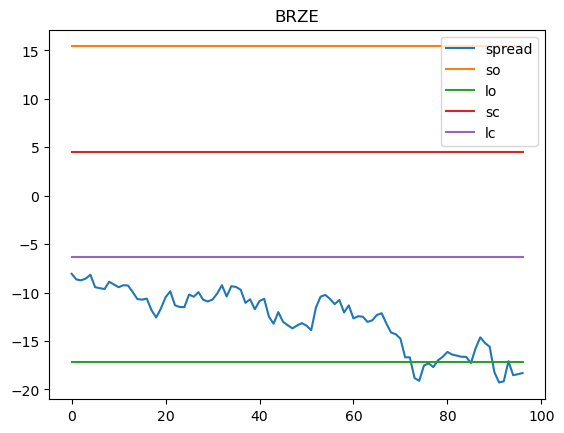

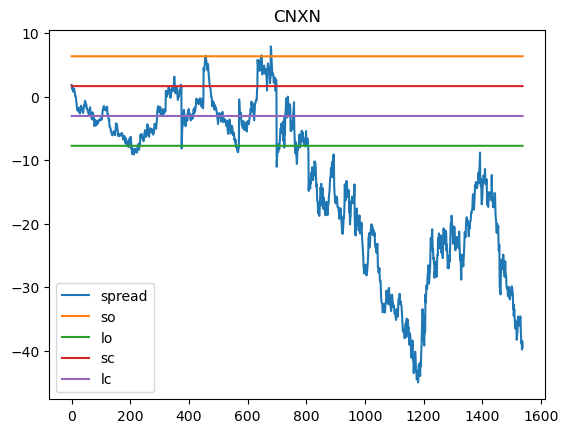

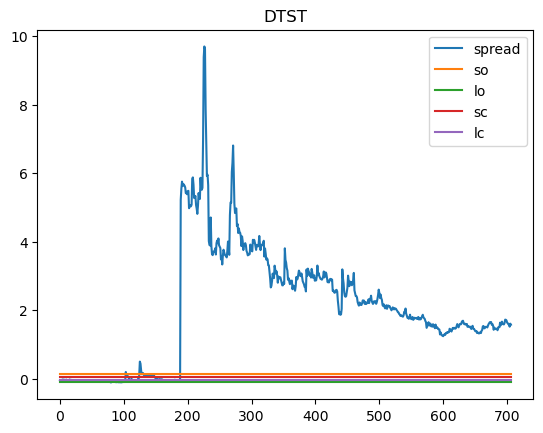

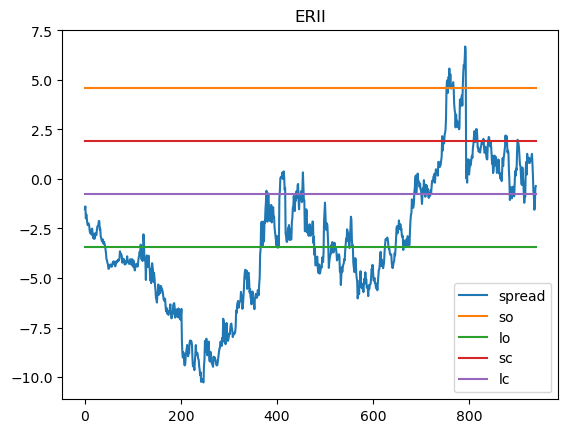

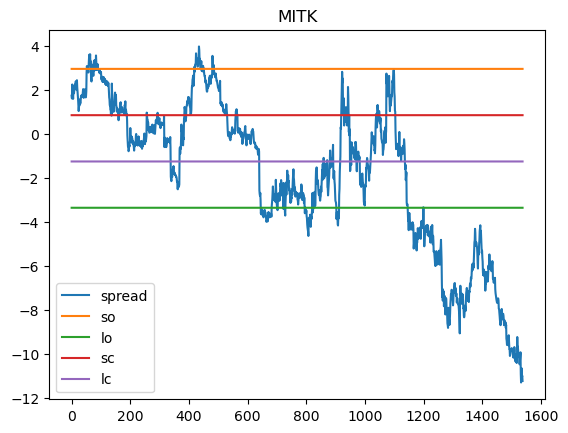

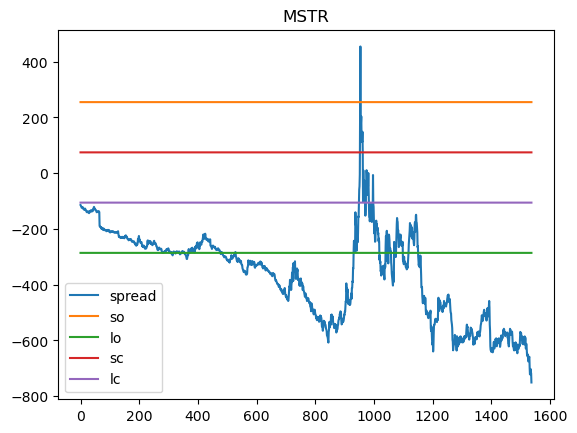

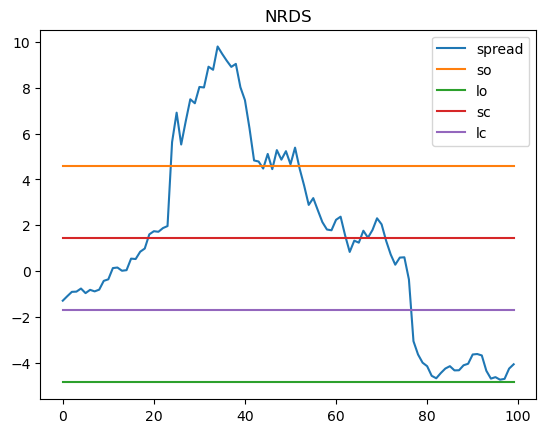

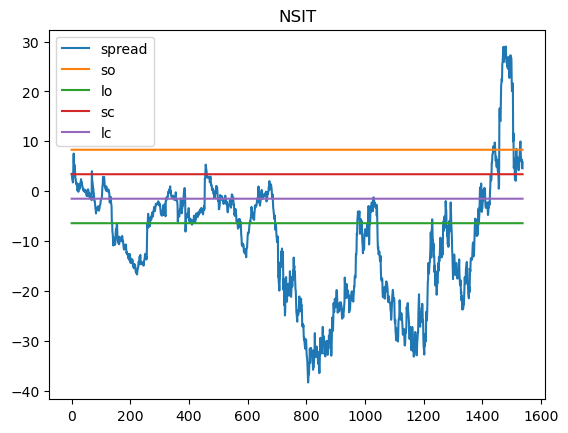

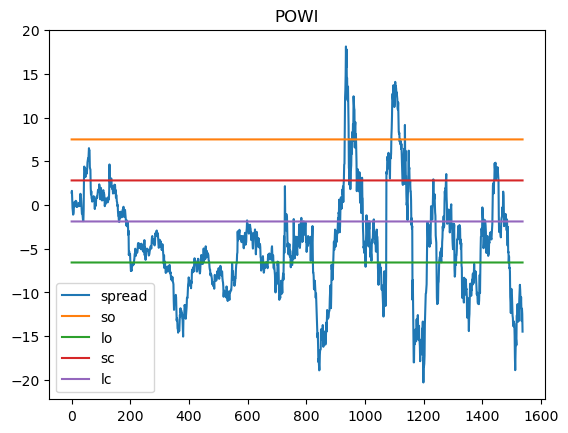

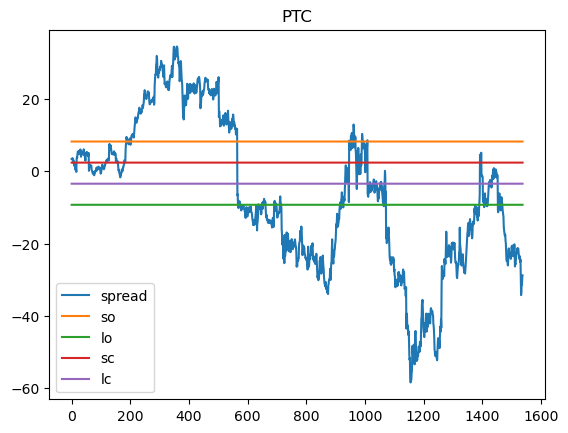

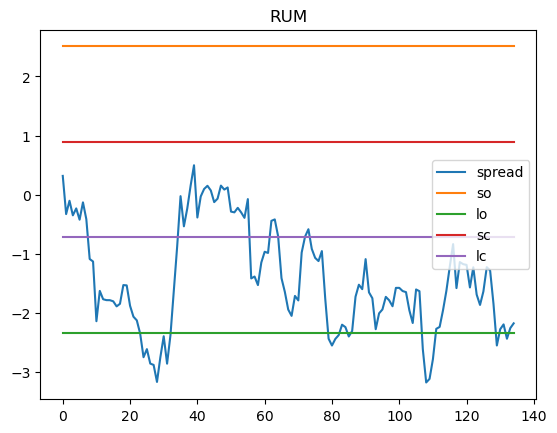

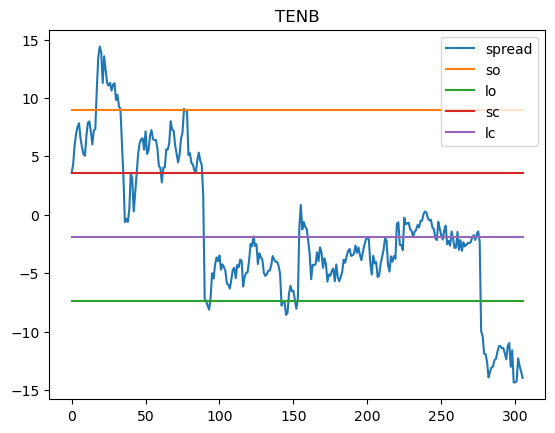

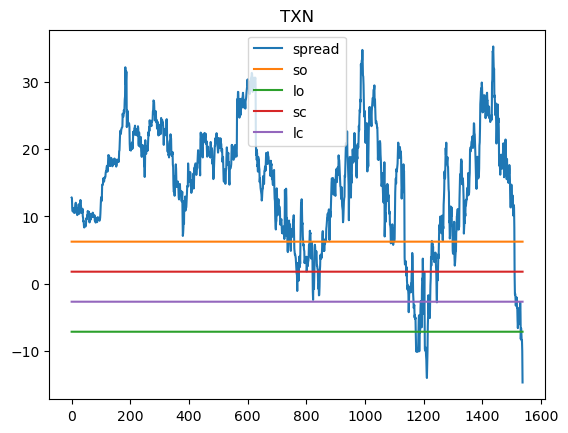

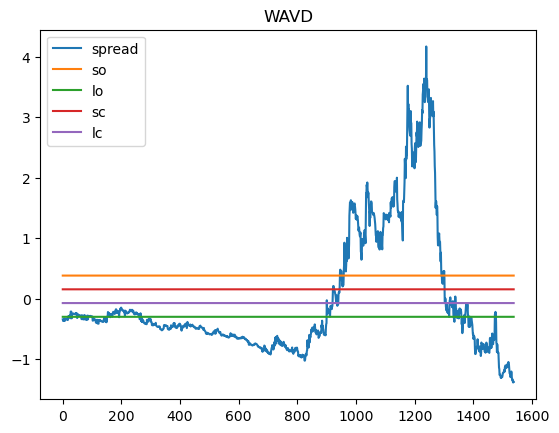

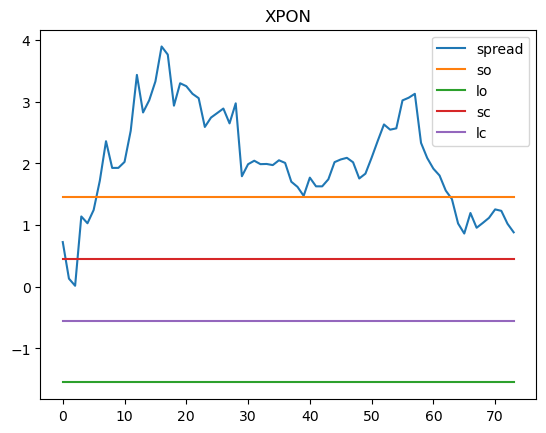

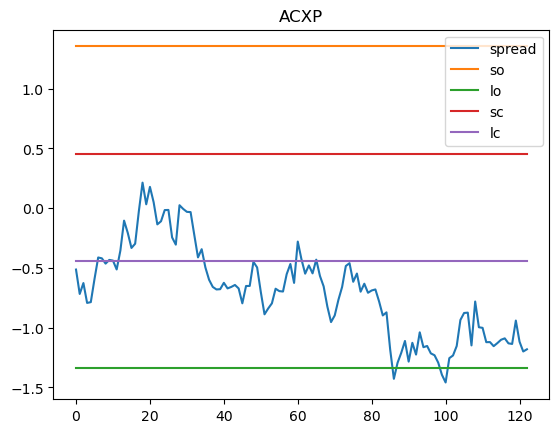

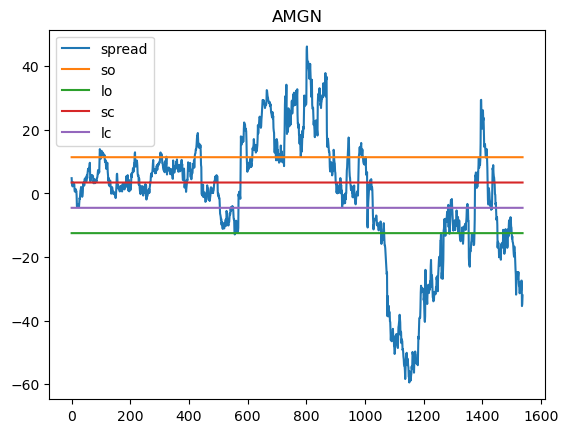

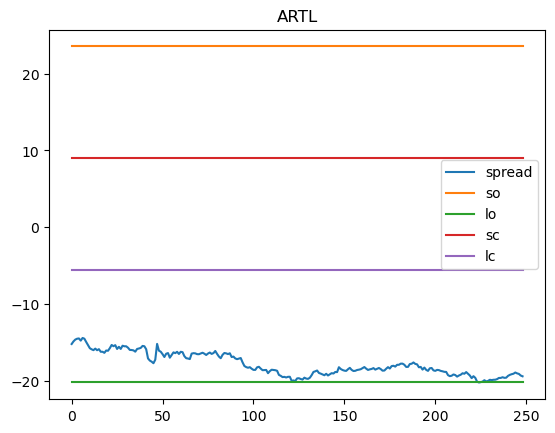

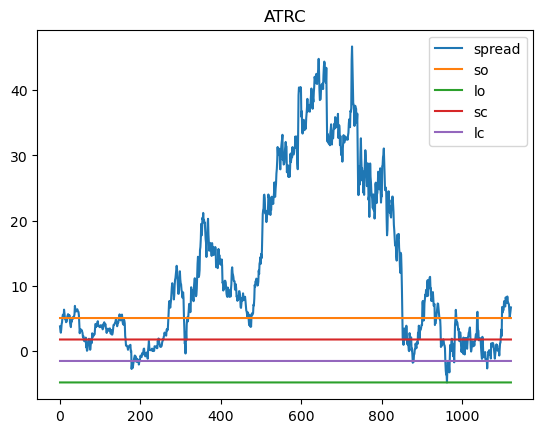

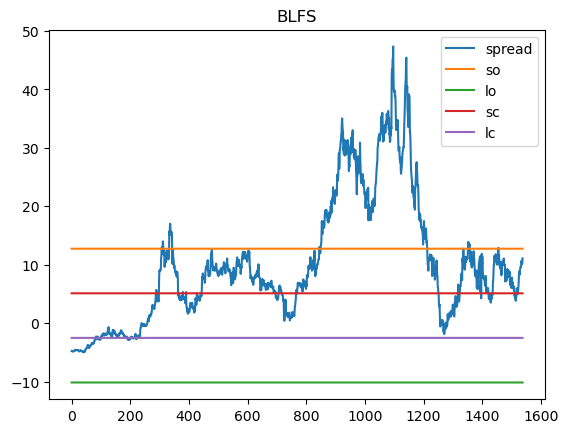

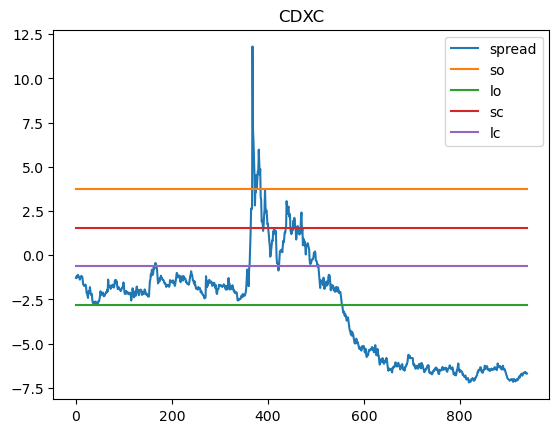

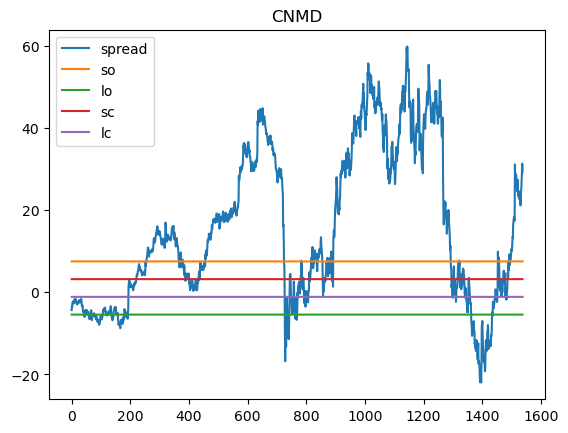

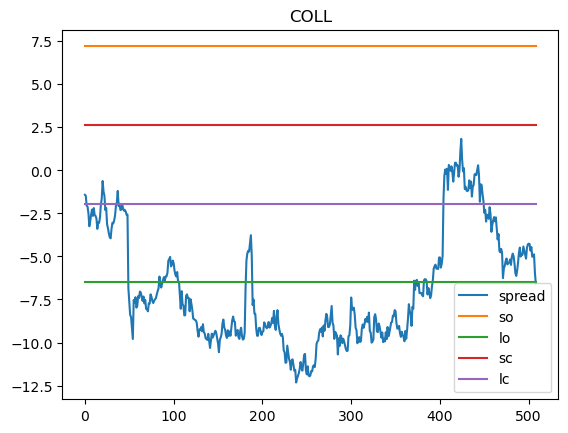

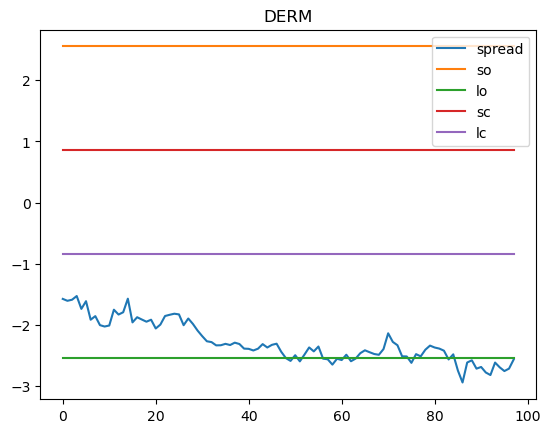

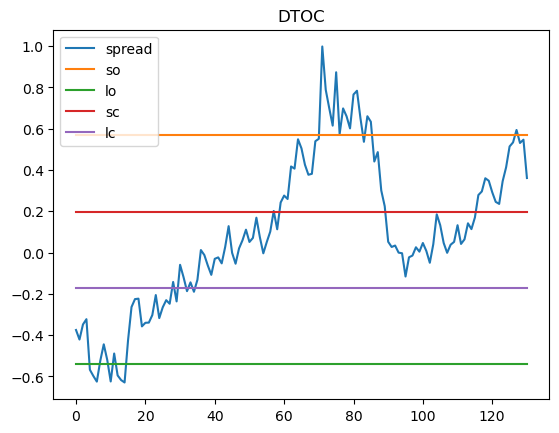

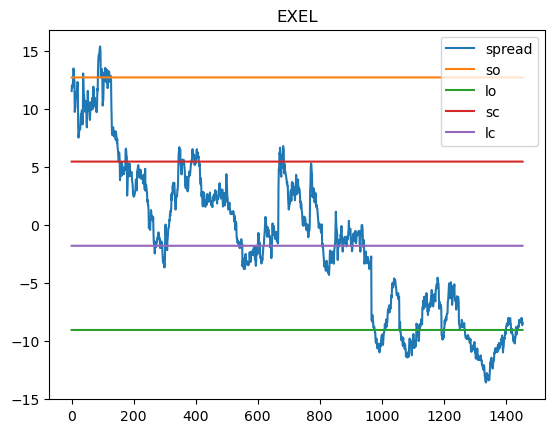

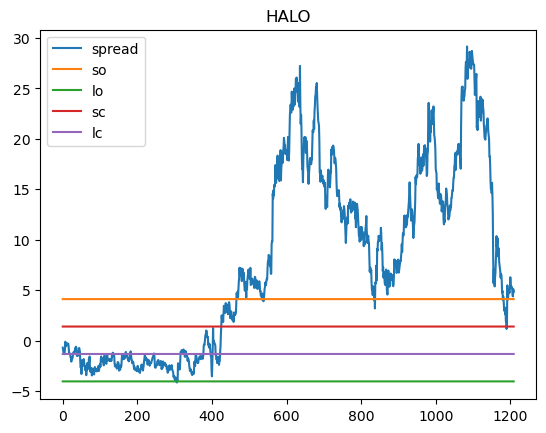

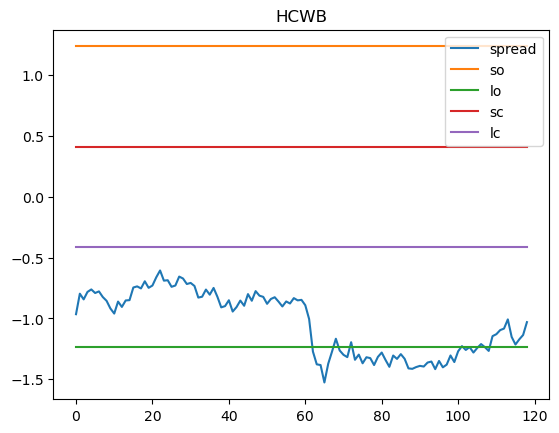

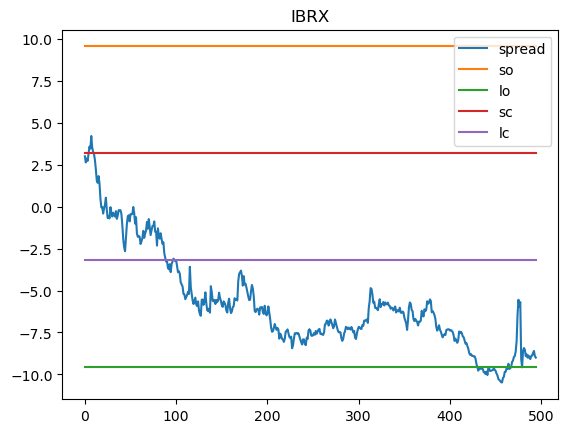

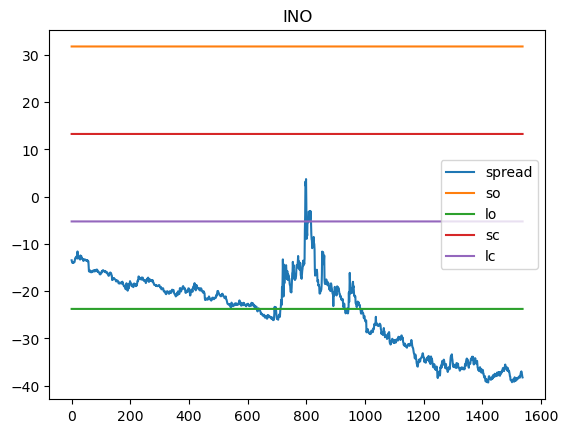

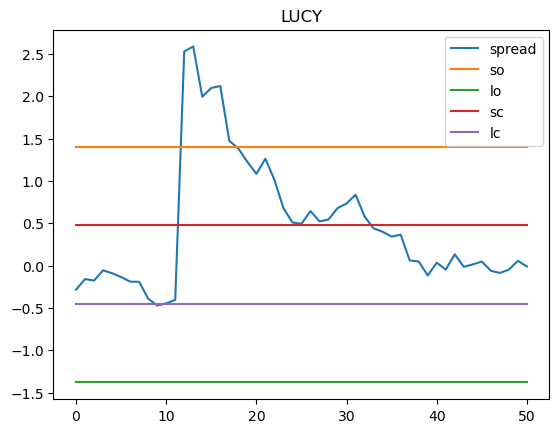

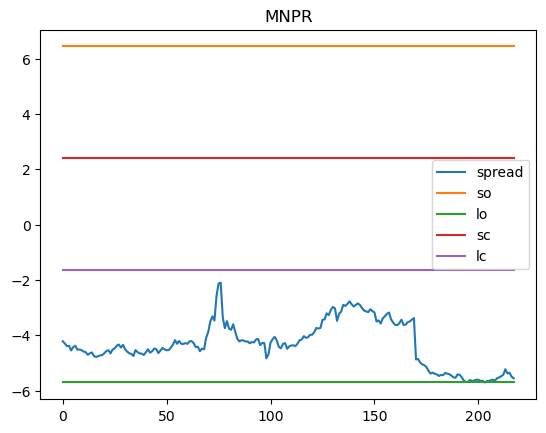

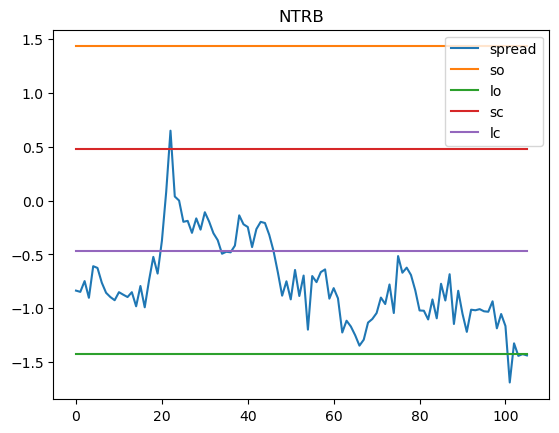

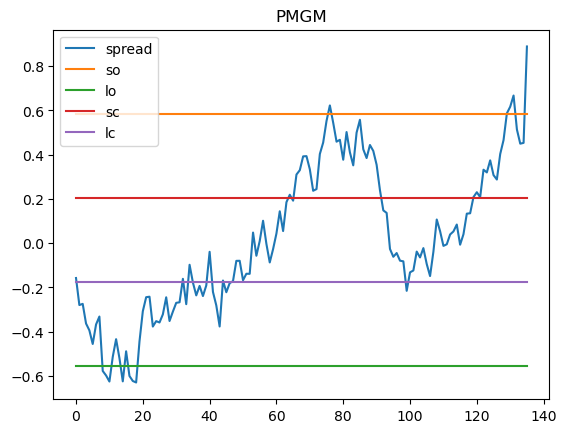

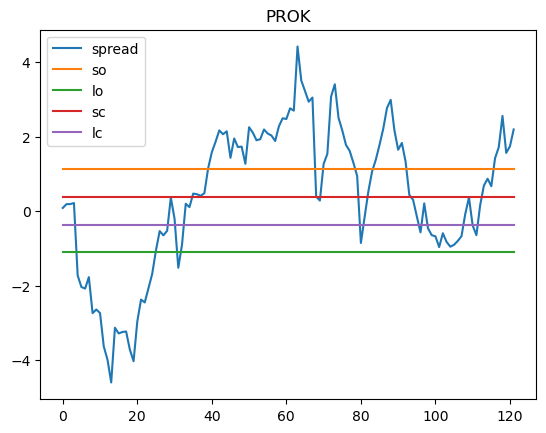

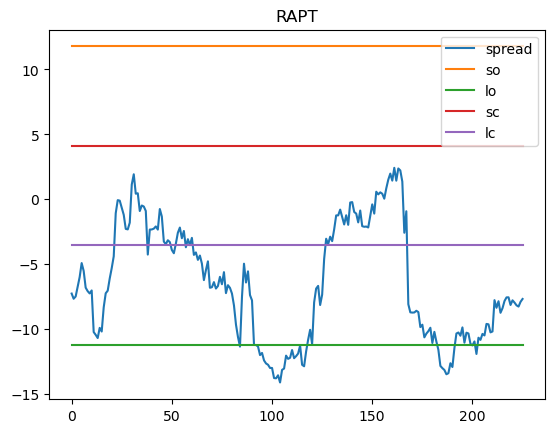

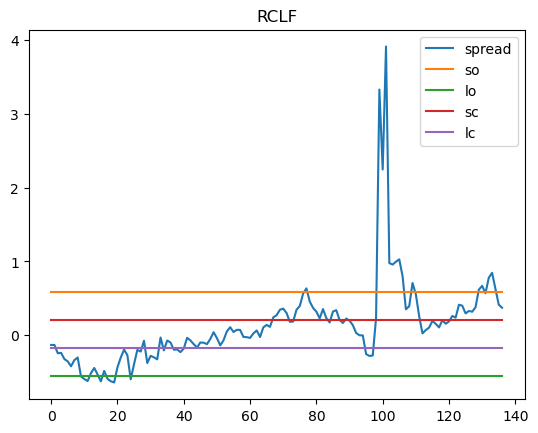

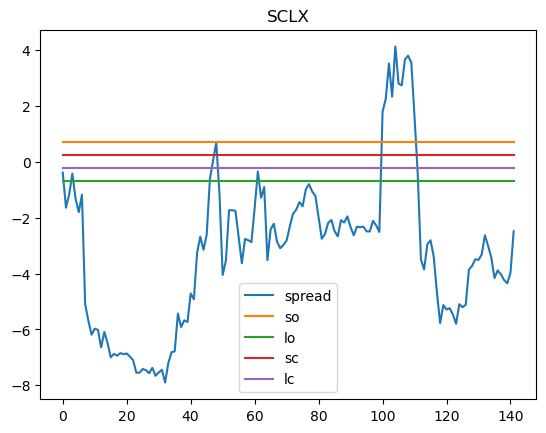

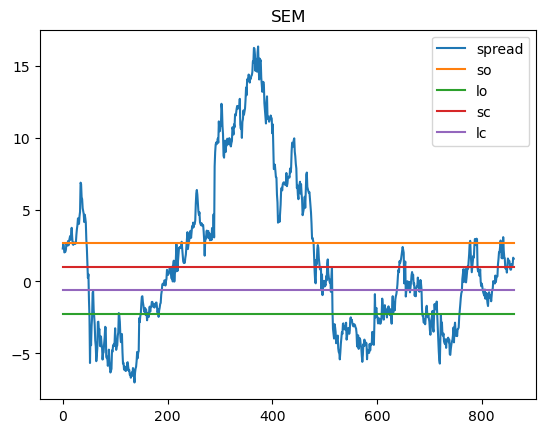

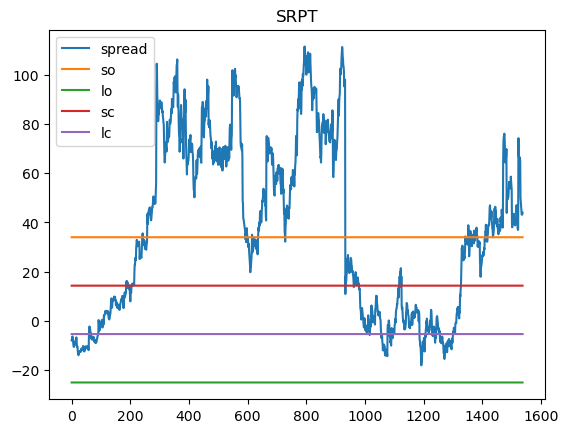

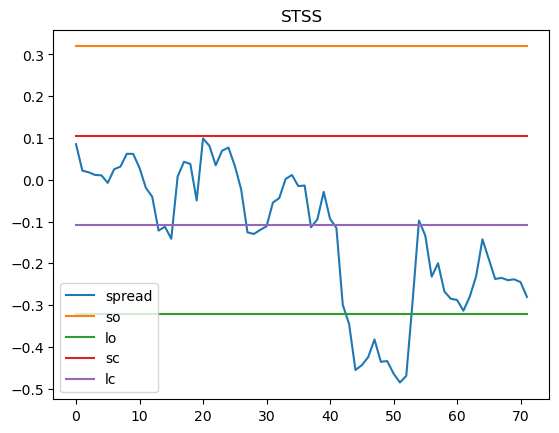

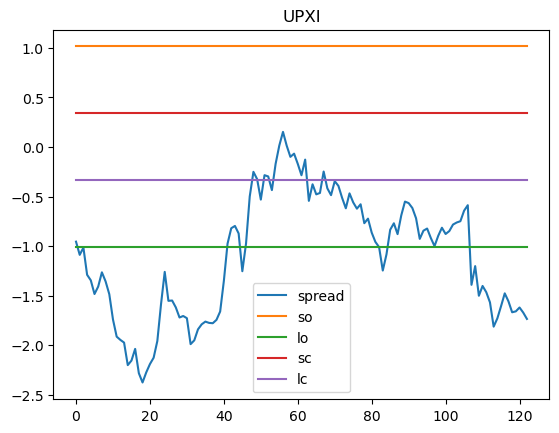

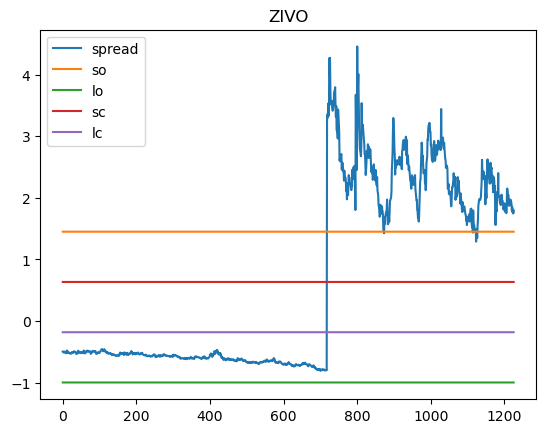

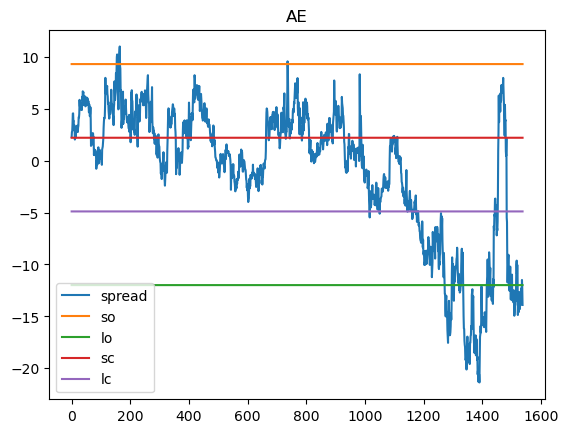

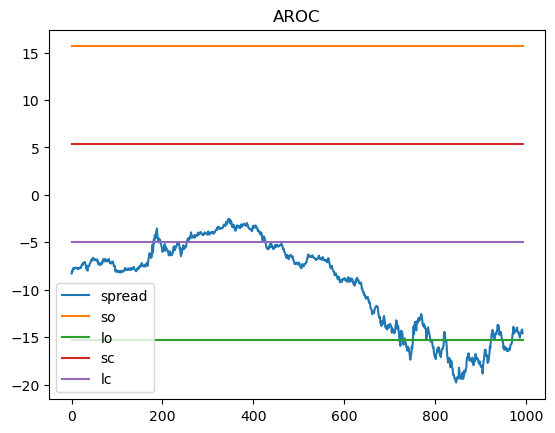

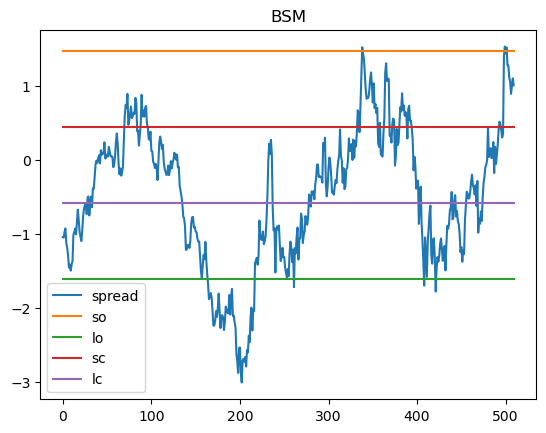

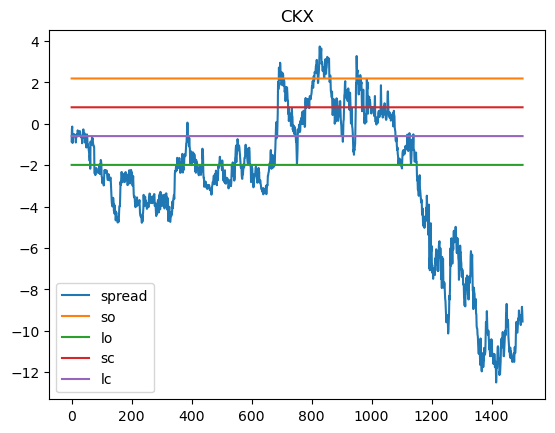

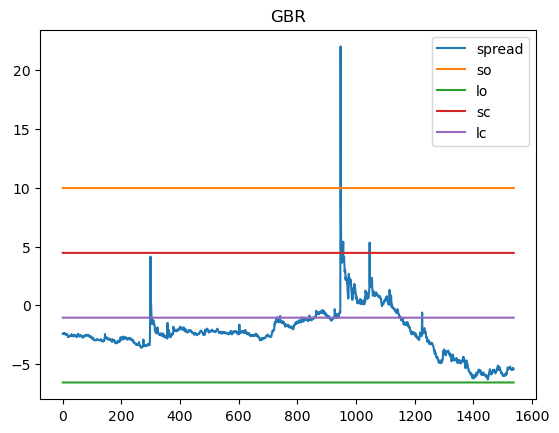

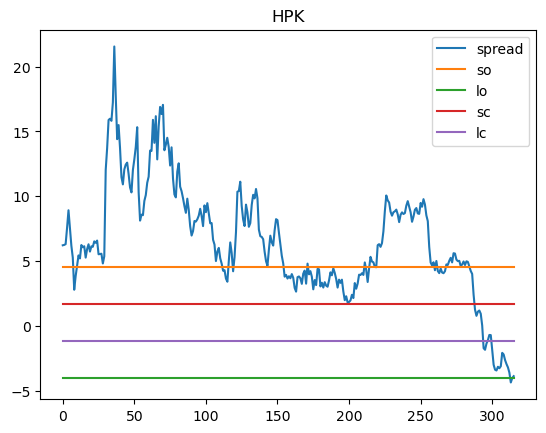

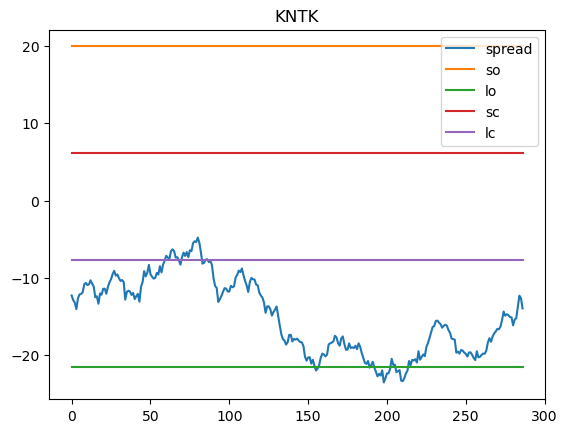

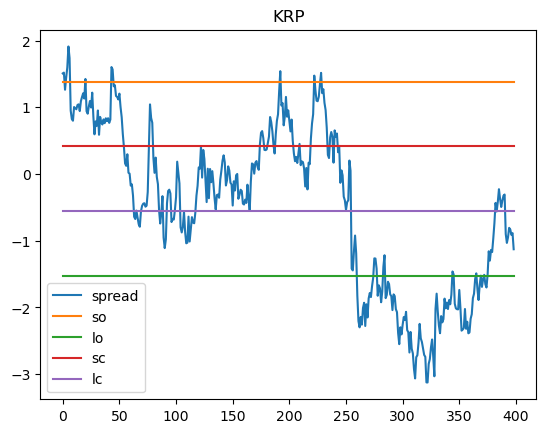

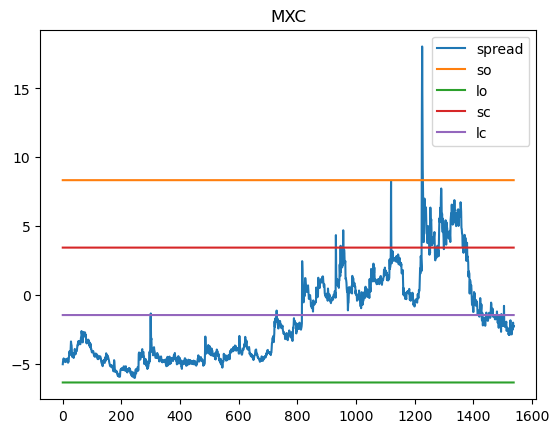

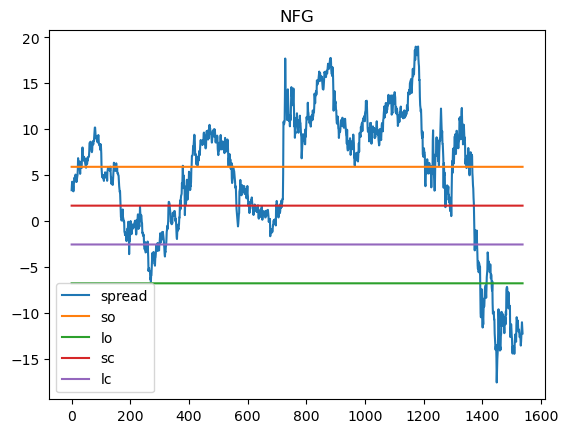

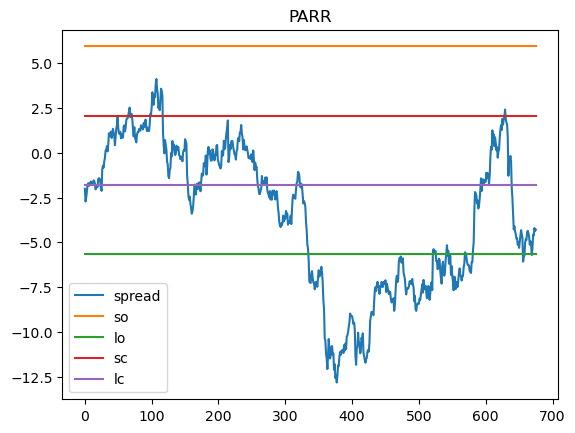

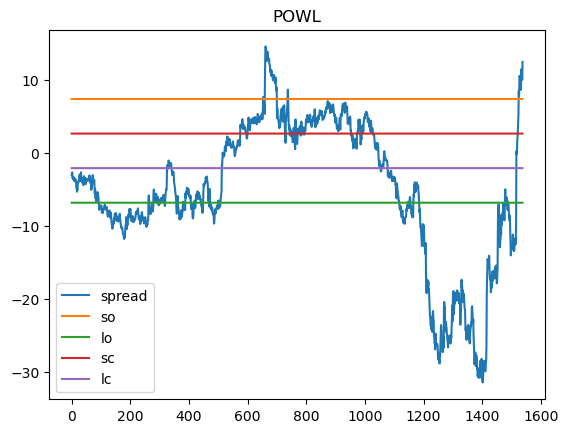

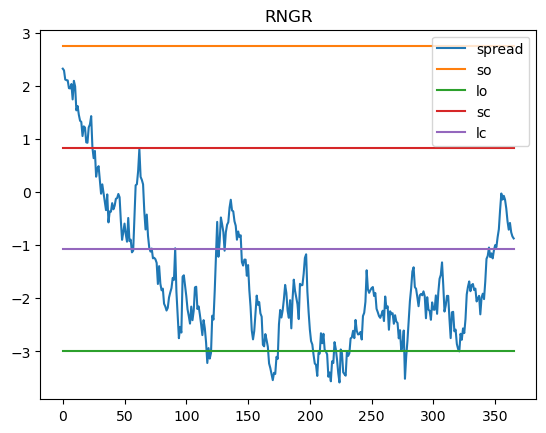

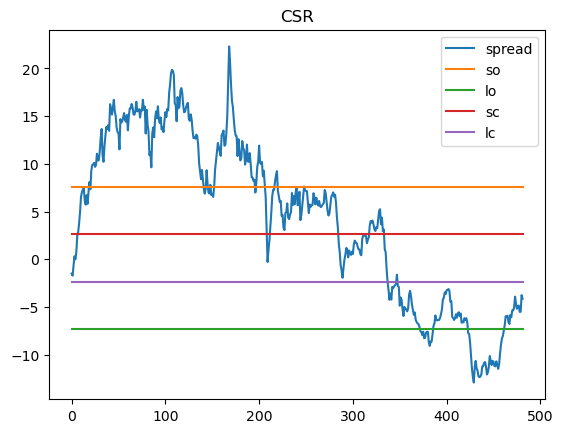

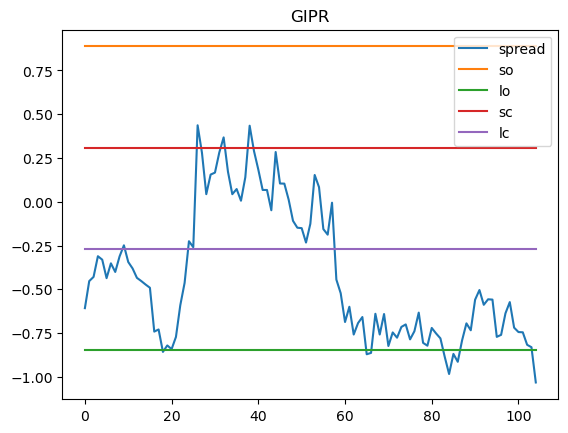

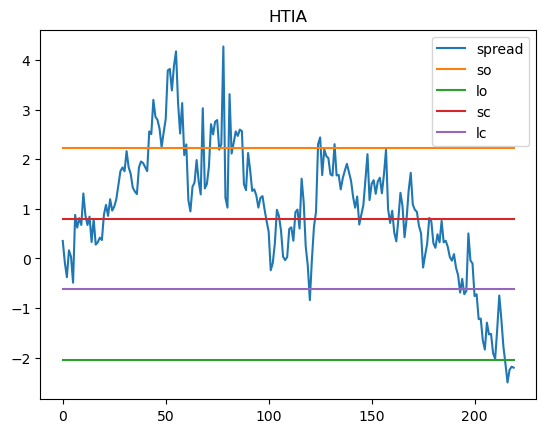

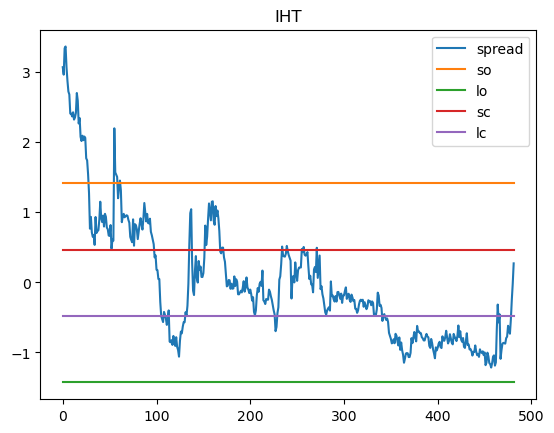

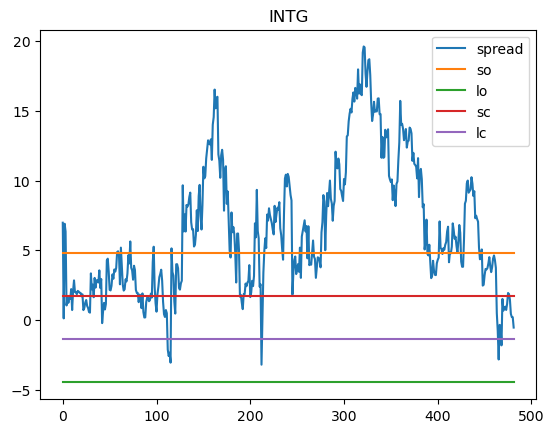

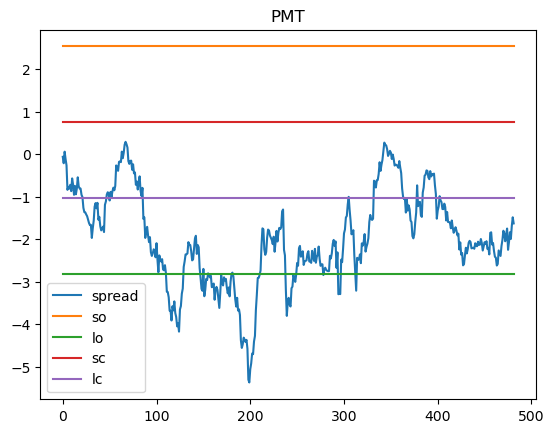

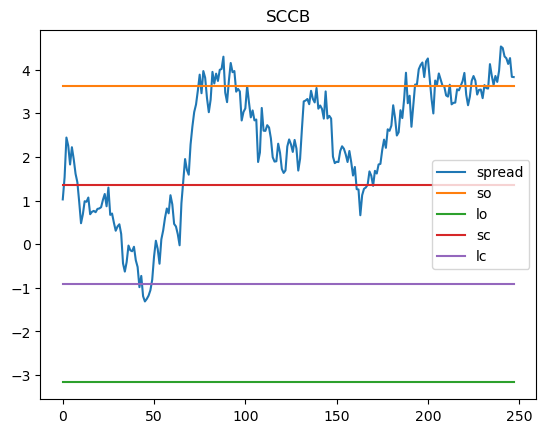

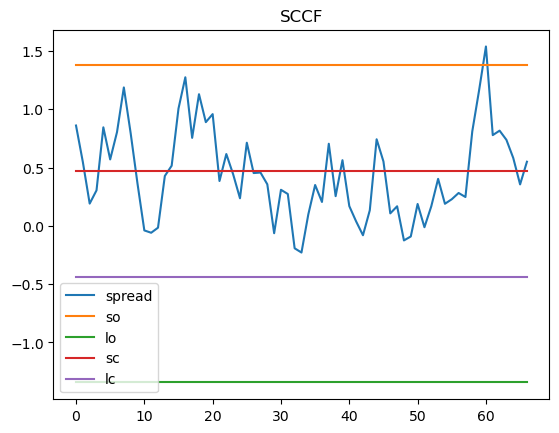

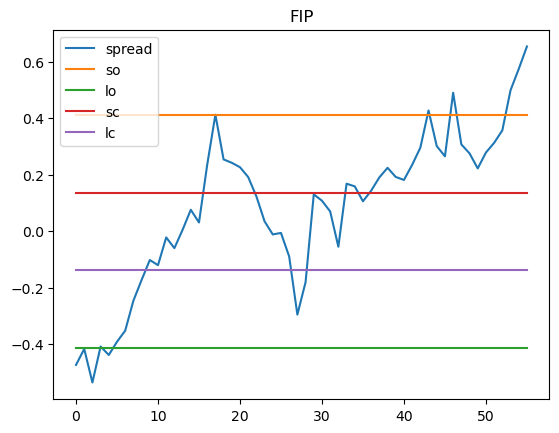

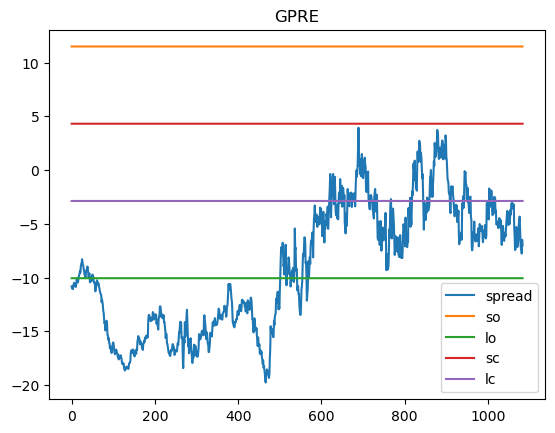

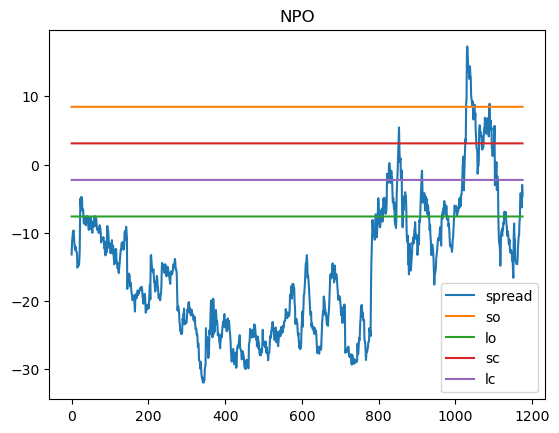

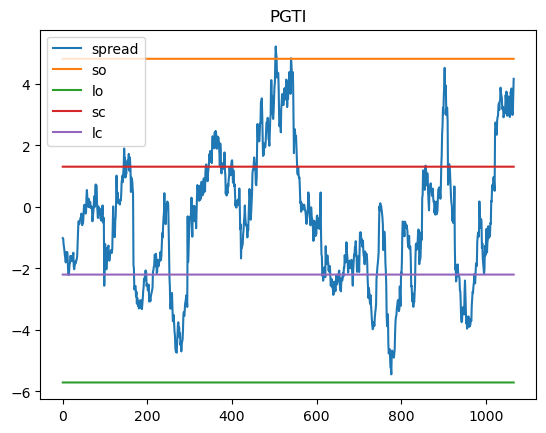

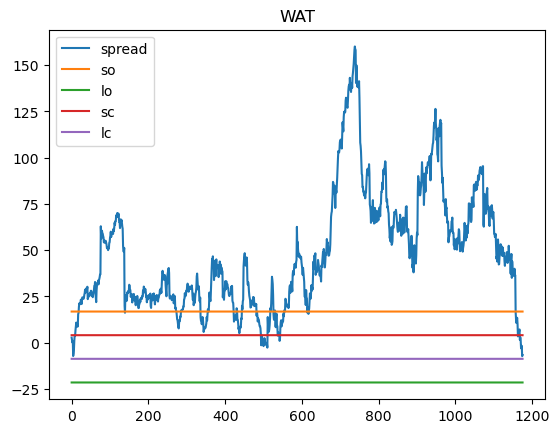

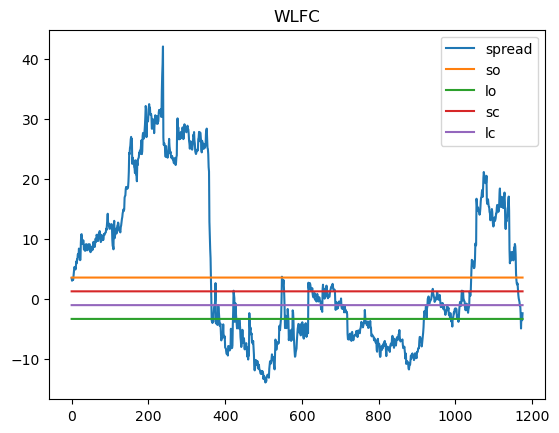

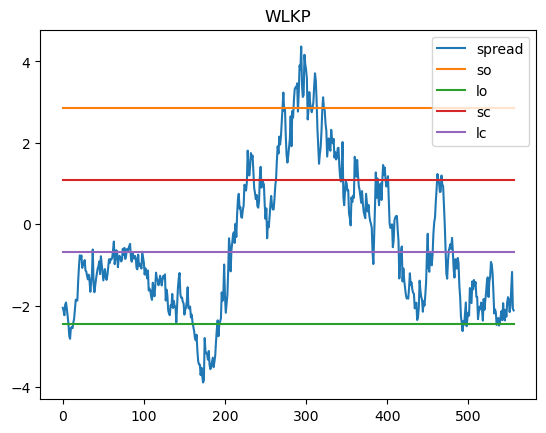

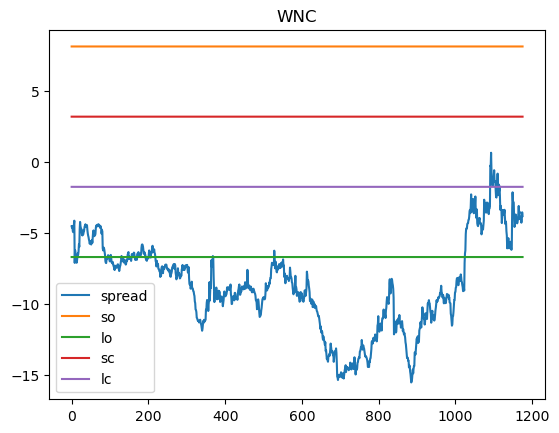

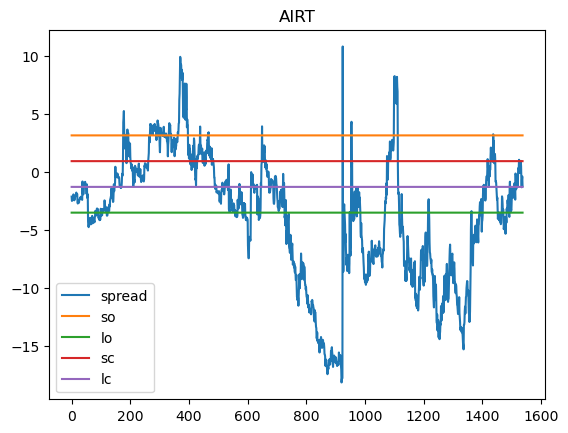

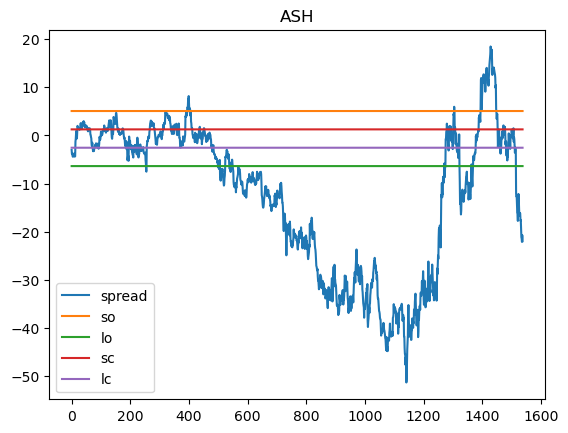

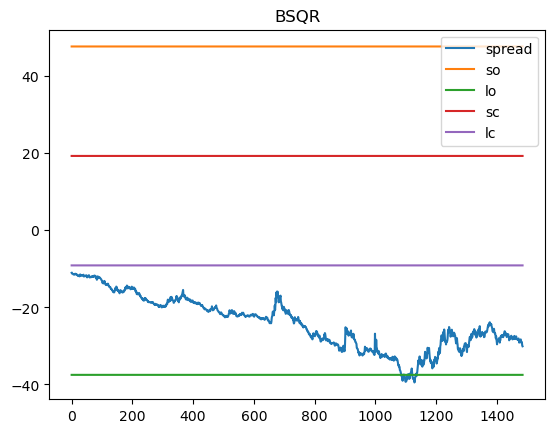

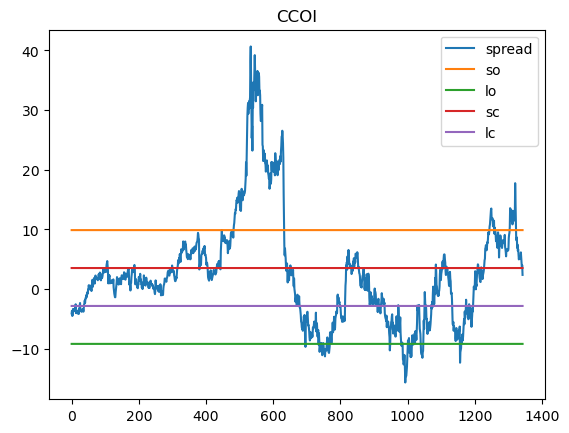

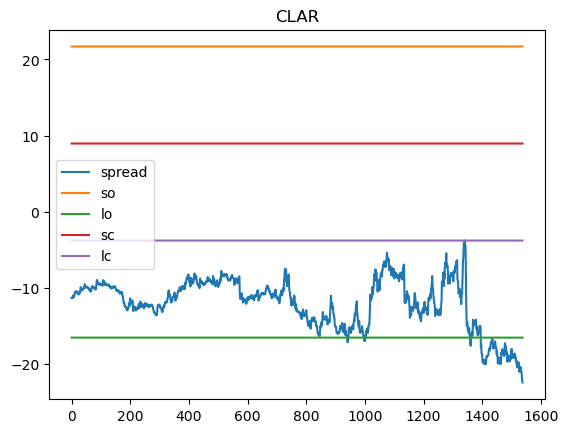

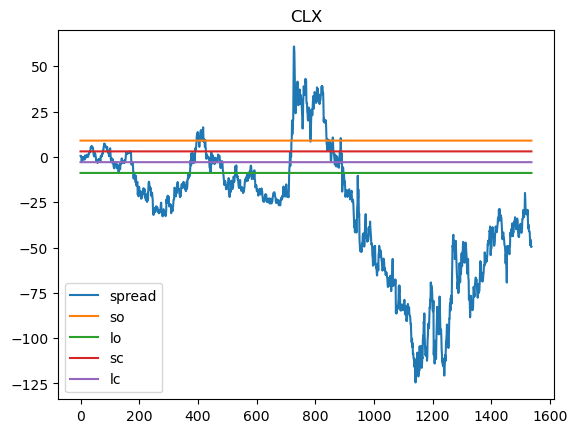

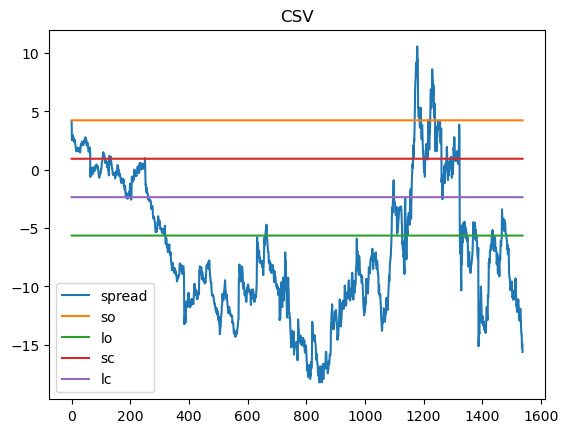

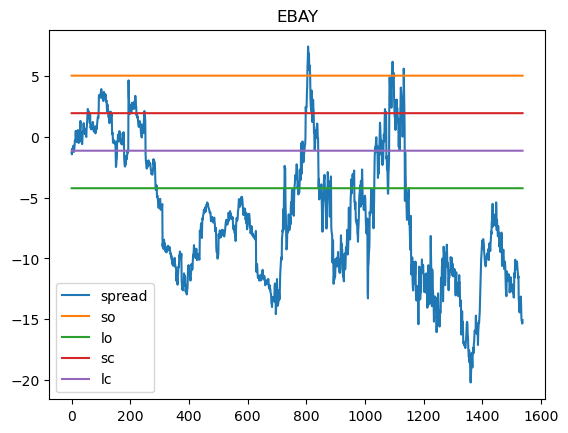

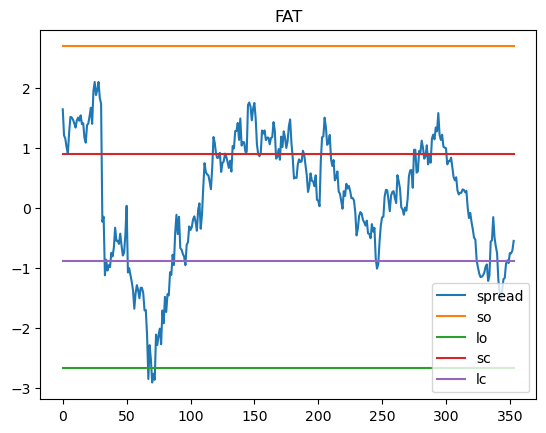

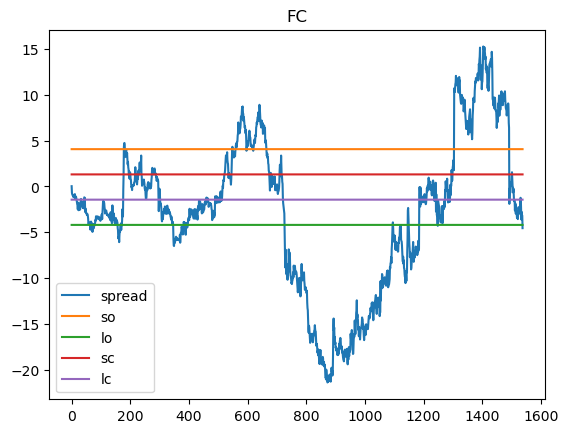

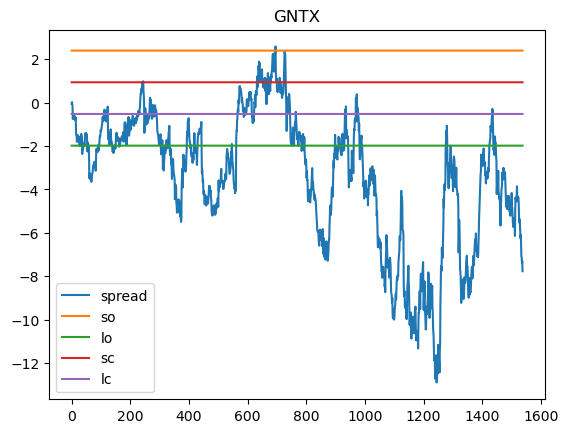

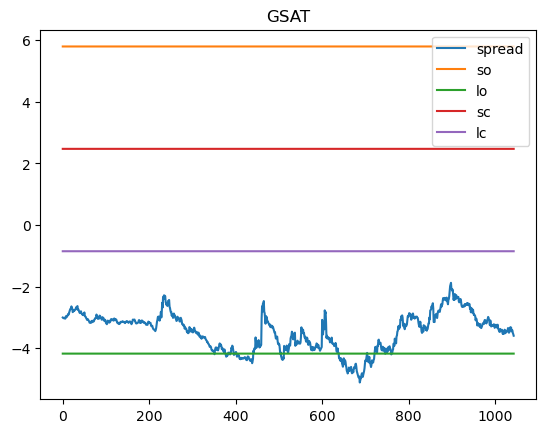

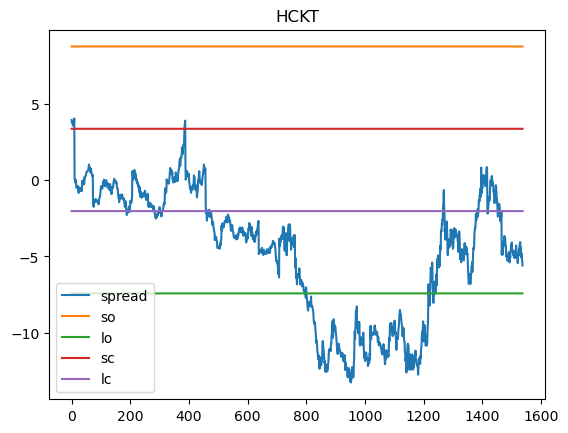

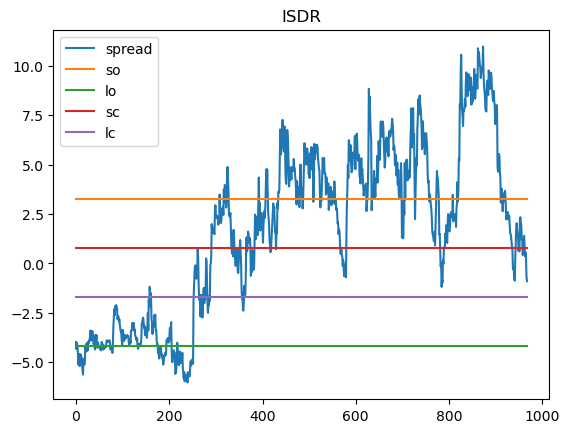

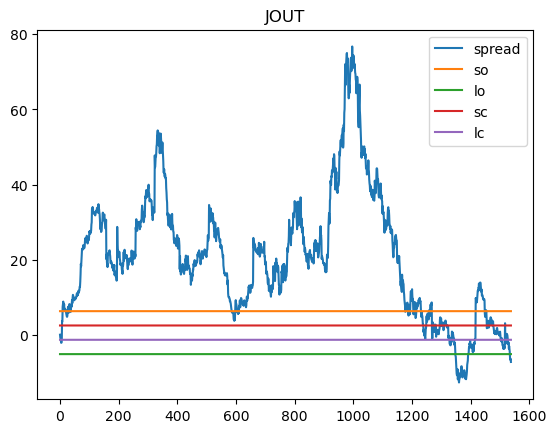

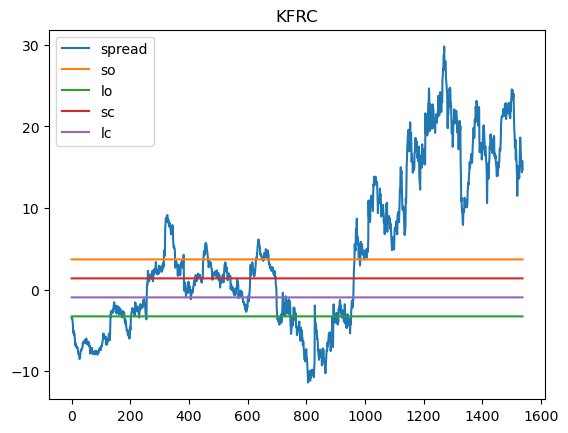

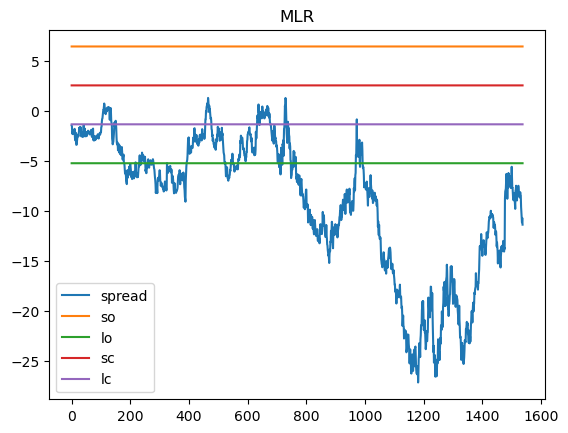

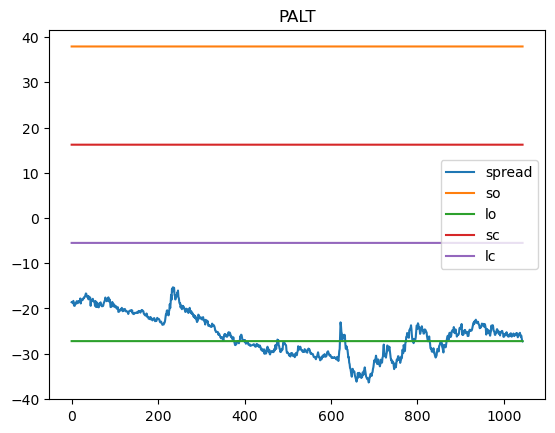

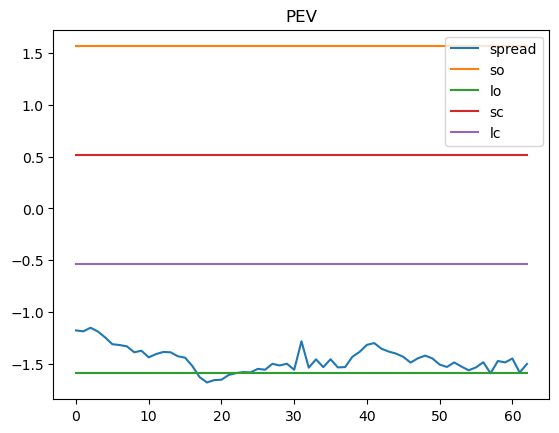

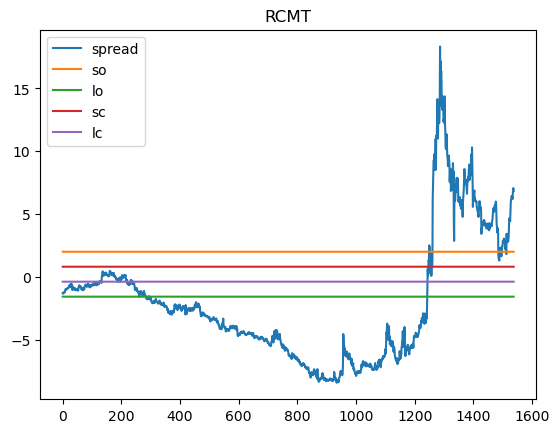

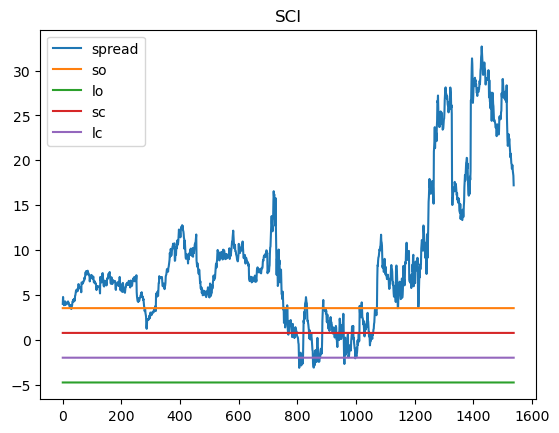

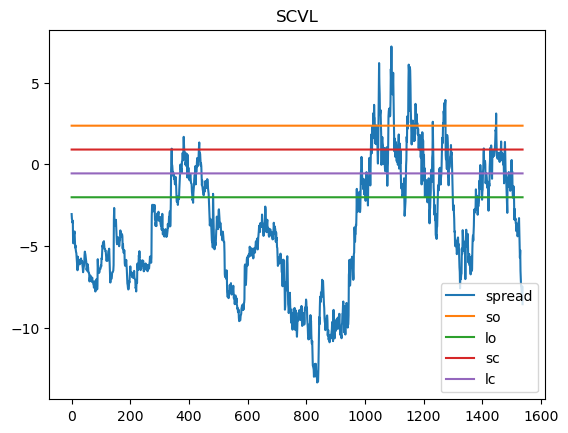

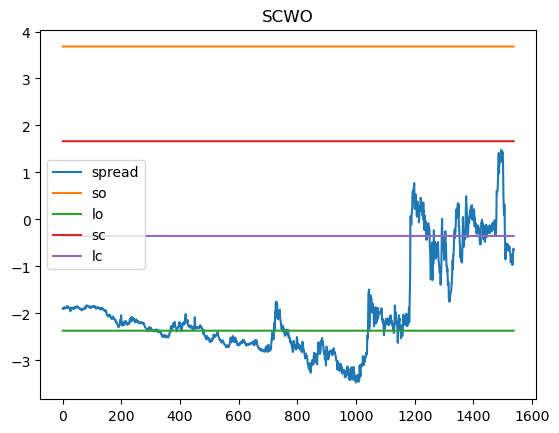

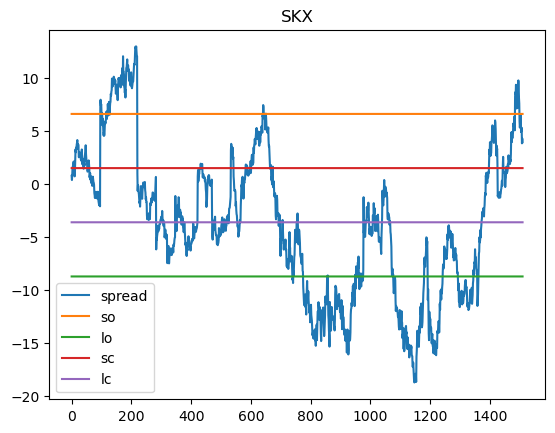

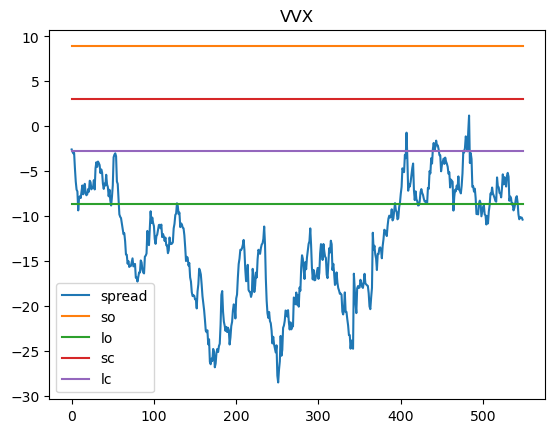

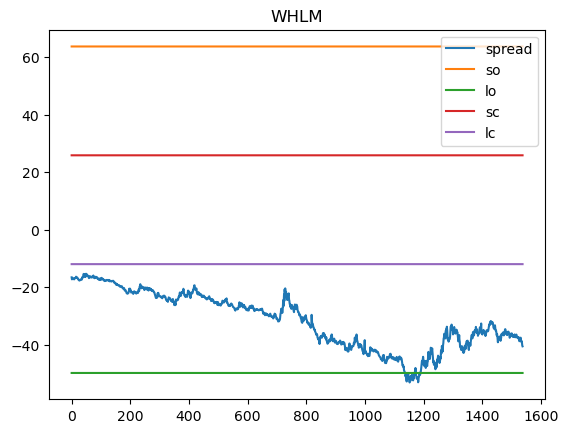

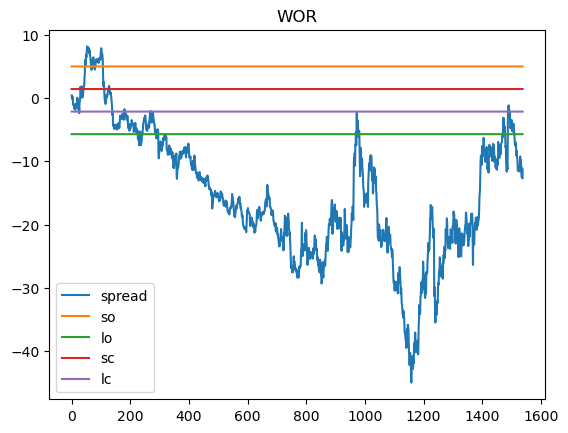

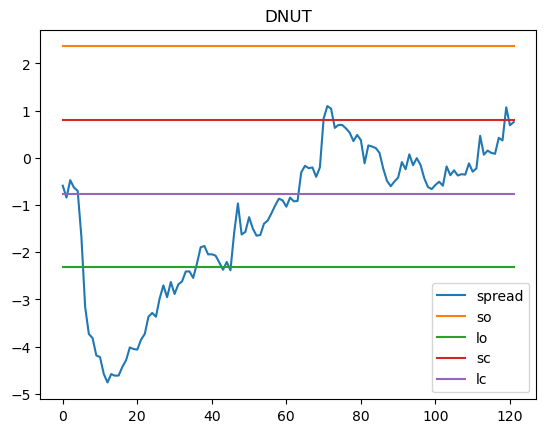

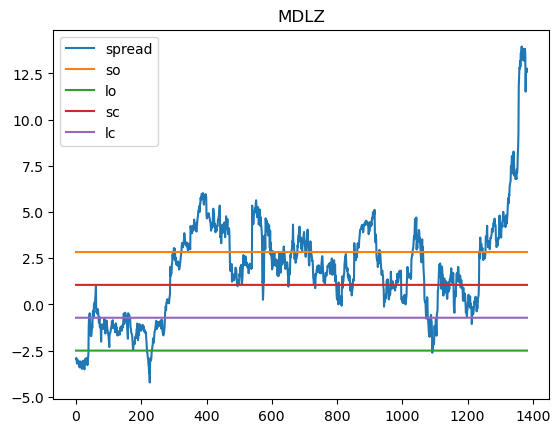

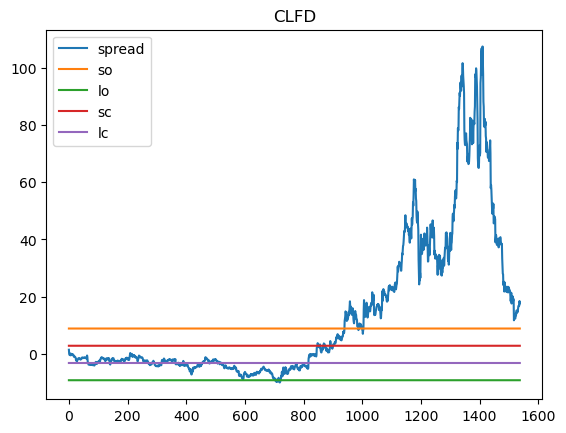

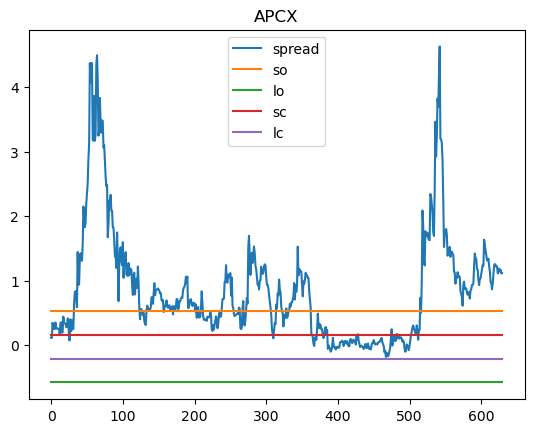

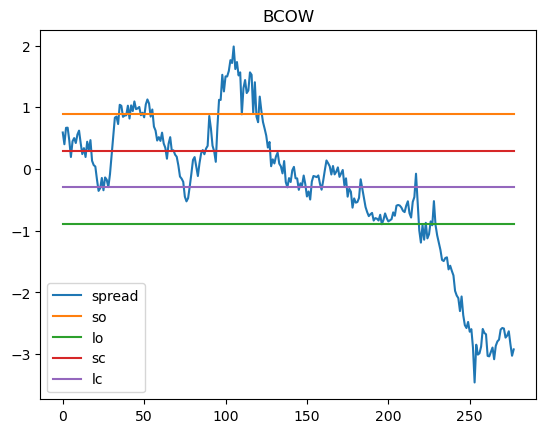

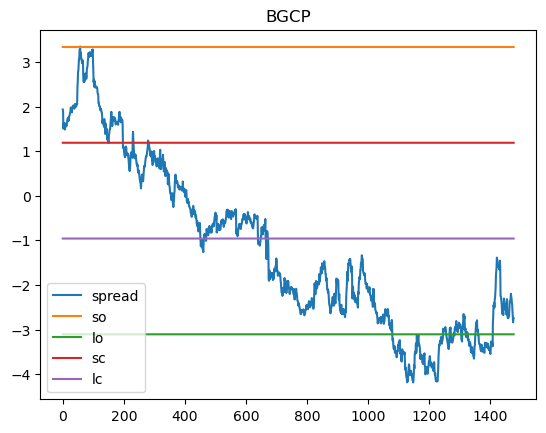

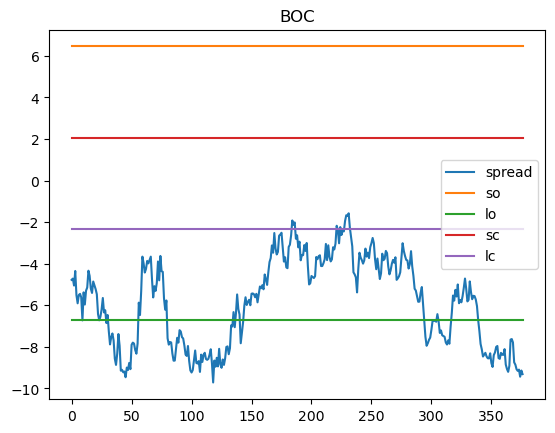

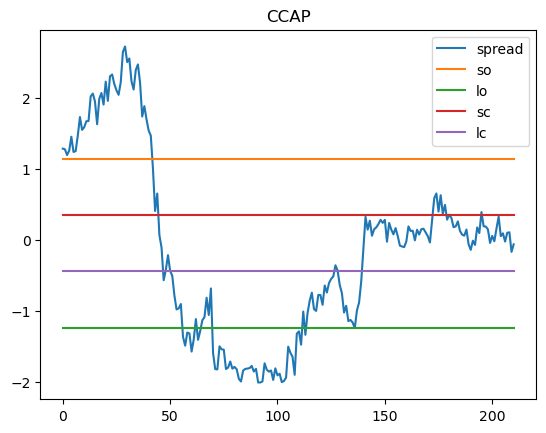

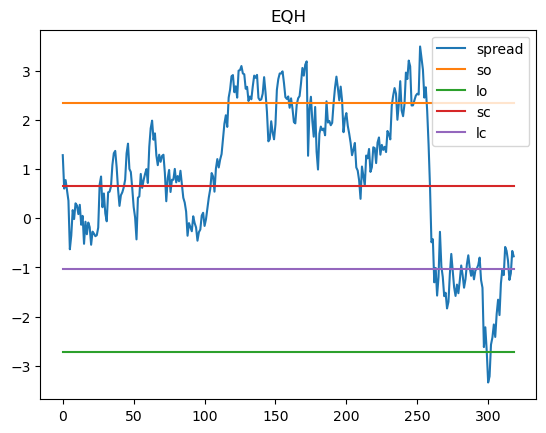

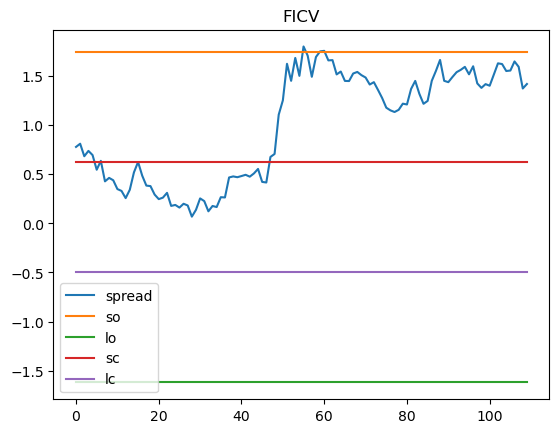

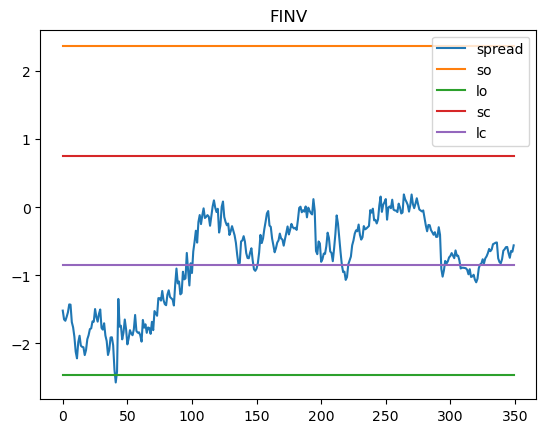

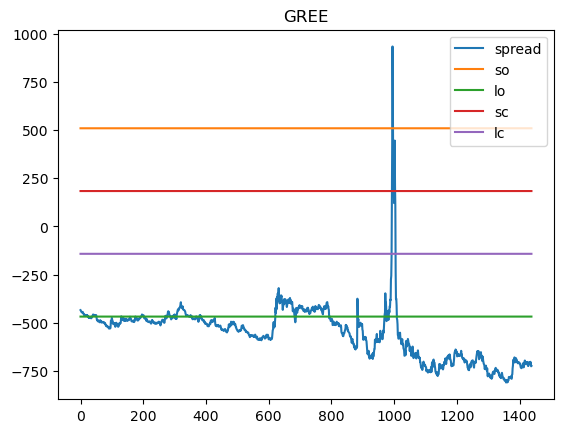

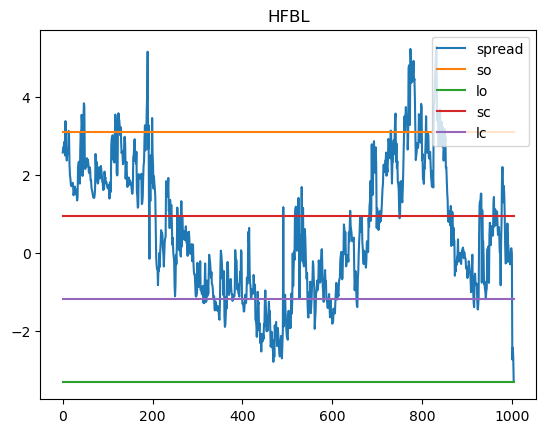

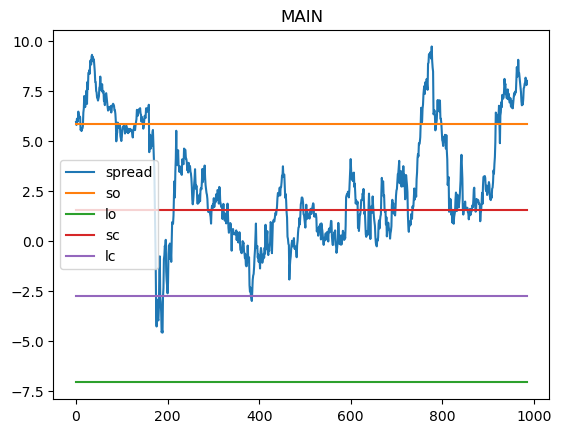

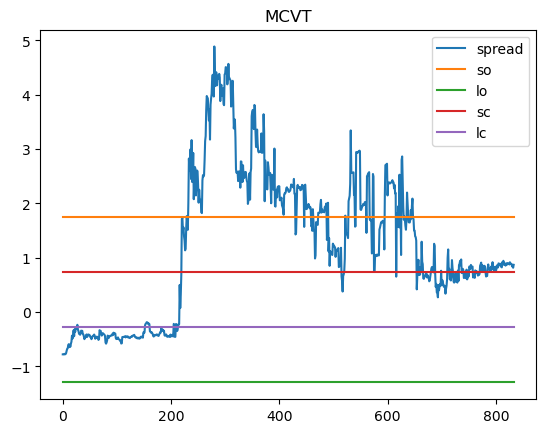

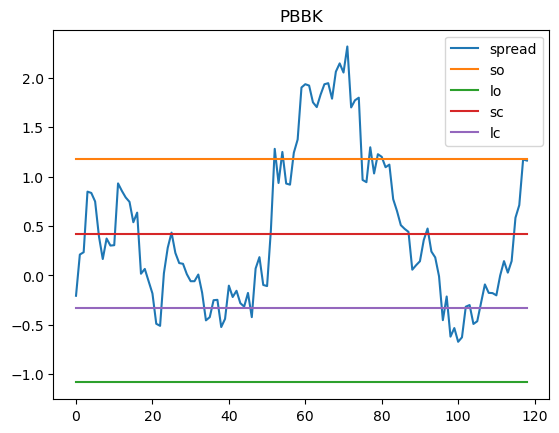

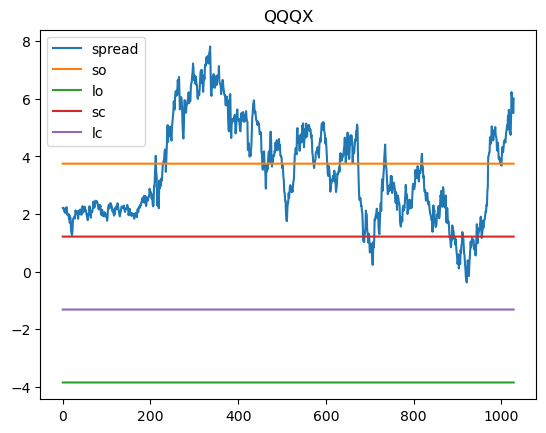

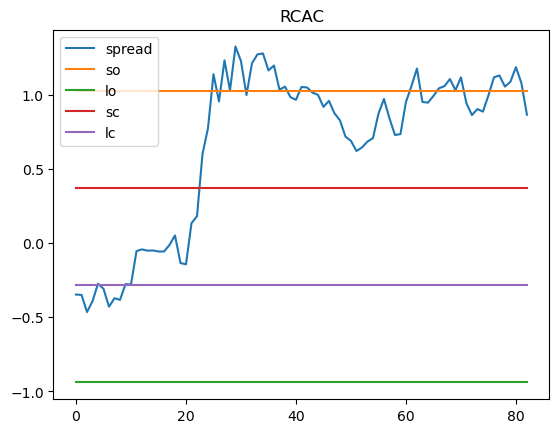

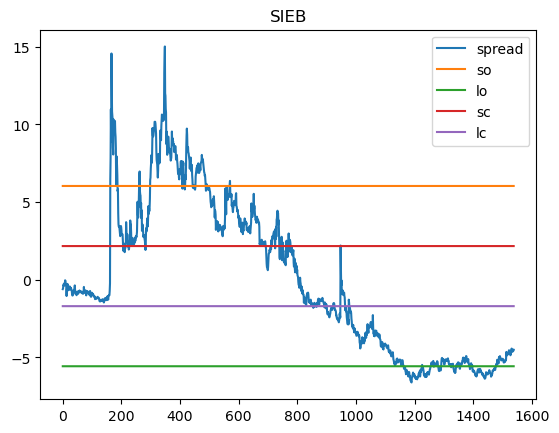

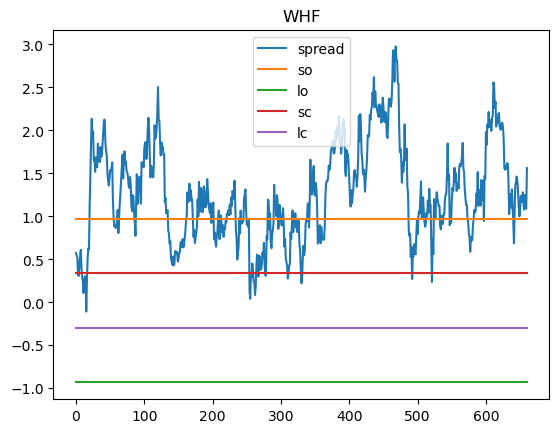

In [77]:
for pair in good_pairs:
    etf = pair[1]
    eq = pair[0]
    if etf == 'XLK':
        merged_data = tech_dfs[eq]
    elif etf == 'XLV':
        merged_data = hc_dfs[eq]
    elif etf == 'XLE':
        merged_data = energy_dfs[eq]
    elif etf == 'XLRE':
        merged_data = re_dfs[eq]
    elif etf == 'VIS':
        merged_data = ind_dfs[eq]
    elif etf == 'XLY':
        merged_data = cd_dfs[eq]
    elif etf == 'XLP':
        merged_data = cs_dfs[eq]
    elif etf == 'XLU':
        merged_data = util_dfs[eq]
    elif etf == 'XLF':
        merged_data = fin_dfs[eq]
    
    length = merged_data.shape[0]
    sample_len = math.floor(length*0.75)
    insample = merged_data.iloc[0:sample_len]
    outsample = merged_data.iloc[sample_len:]
    ols = sm.OLS(np.array(insample['Close']),np.array(insample['Close ETF']))
    res = ols.fit()
    beta = res.params[0]
    insample_spread = np.subtract(np.array(insample['Close']),beta*np.array(insample['Close ETF']))
    mean = np.mean(insample_spread)
    sd = np.std(insample_spread)
    spread = np.subtract(np.array(outsample['Close']),beta*np.array(outsample['Close ETF']))
    short_open = mean + 1.5 * sd
    long_open = mean - 1.5 * sd
    long_close = mean - 0.5 * sd
    short_close = mean + 0.5 * sd
    
    #prof, num_trades = outsample_pairs_trade(spread,short_open,long_open,short_close,long_close,10000)
    
    plt.figure()
    plt.plot(np.arange(spread.shape[0]),spread, label='spread')
    plt.plot(np.arange(spread.shape[0]),np.ones(spread.shape[0])*short_open,label='so')
    plt.plot(np.arange(spread.shape[0]),np.ones(spread.shape[0])*long_open,label='lo')
    plt.plot(np.arange(spread.shape[0]),np.ones(spread.shape[0])*short_close,label='sc')
    plt.plot(np.arange(spread.shape[0]),np.ones(spread.shape[0])*long_close,label='lc')
    plt.legend()
    plt.title(eq)
    